# Trabalho Final 

Alunos:

  - Daniel Vieira
  - Rodrigo Passos

## Código da Simulação


In [ ]:
import random
import math 
import copy
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown
import scipy.stats
import networkx as nx
from graphviz import Graph
from IPython.display import Image
!sudo apt-get -qq install -y graphviz graphviz-dev && pip install pygraphviz
import pygraphviz

In [ ]:
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (round(m*10000)/10000, round((m-h)*10000)/10000, round((m+h)*10000)/10000)
    
def simulator(simT, arrR, serR, k, tp, graphs):
  if graphs:
    display(Markdown(
          f"### Simulation: simT={simT}, " +
          f"$\lambda$={format(arrR)}, " +
          f"$\mu$={format(serR)}, " +
          f"$1/\lambda$={format(1.0/arrR)}, " +
          f"$1/\mu$={format( 1.0/serR)}, " + 
          f"$\Qtd_de_Servidores$={format(k)}" 
      ))
  
  # Intervalo de Confiança

  arrivalList = []
  serviceList = []
  startList = []
  departureList = []
  serverList = [] 
  # record the departure times of servers that are busy

  # generate arrival time list (indepedent)
  arrivalTime = 0
  while arrivalTime < simT:
      arrivalTime += random.expovariate(arrR)
      arrivalList.append(arrivalTime)

  '''
  Show ArrivalList
  '''
  printArrivalList = [round(a, 3) for a in arrivalList]
  # print(printArrivalList)
  aList = copy.copy(arrivalList)

  
  # run simulation
  currentTime = 0
  count_sistema = 0 
  count_fila = 0
  qnt_list = []

  while currentTime < simT:
      flag_add = False
      currentTime = aList[0] # time stamp for reference
      if len(serverList) < k:
          startTime = aList[0] # time when the job began
      else: 
          startTime = serverList[serverList.index(min(serverList))]
          qnt_pessoa = len(serverList)-1
          for i in aList:
              if i < min(serverList):
                  qnt_pessoa+=1
              else:break
          qnt_list.append(qnt_pessoa)
          del(serverList[serverList.index(min(serverList))])
      startList.append(startTime)
      if tp == 'm':
        serviceTime = random.expovariate(serR)
      else:
        serviceTime = 1/serR
      serviceList.append(serviceTime)
      departureTime = startTime + serviceTime
      departureList.append(departureTime)
      serverList.append(departureTime)
      aList.pop(0)
      if len(aList) == 0: 
        break
      # Loop to determine the wait time in the queue 
      while len(serverList) > 0:
          if serverList[serverList.index(min(serverList))] < aList[0]:
              qnt_pessoa = len(serverList)-1
              for i in aList:
                  if i < min(serverList):
                      qnt_pessoa+=1
                  else:
                      break
              qnt_list.append(qnt_pessoa)
              del(serverList[serverList.index(min(serverList))])
          else: break
      
  
  '''
  Performance Measure
  '''
  waitList = [startList[i] - arrivalList[i] for i in range(len(startList))]
  departureList = [startList[i] + serviceList[i] for i in range(len(startList))]
  response_List = [departureList[i] - arrivalList[i] for i in range(len(departureList))]

  if graphs:
    plt.show()
  
  # [1] plot waiting time 
  # [2] plot service time 
  bins = np.linspace(0, max(serviceList), 11)

  if graphs:
    plt.hist(waitList, bins ,facecolor='red', alpha=0.5,label='Waiting Time (Counts)')
    arr=plt.hist(waitList, bins, facecolor='red', alpha=0.5)
    for i in range(10):
        plt.text(arr[1][i], arr[0][i]+100, str(int(arr[0][i])),color='red')

    plt.hist(serviceList, bins, facecolor='green', alpha=0.5,label='Service Time (Counts')
    arr=plt.hist(serviceList, bins, facecolor='green', alpha=0.5)
    for i in range(10):
        plt.text(arr[1][i], arr[0][i]+100, str(int(arr[0][i])),color='green')

    plt.xlabel('Service Time')
    plt.ylabel('Counts')
    plt.title('Counts of Waiting & Service Time for {} Patients in {} Minutes'.format(len(waitList),simT))
    plt.axis([min(serviceList), max(serviceList),0,len(serviceList)])
    plt.grid(True)
    plt.legend(loc='upper right')
    
    plt.show()

  avgWait = sum(waitList)/len(waitList)
  avgService = sum(serviceList)/len(serviceList)
  avgTime = avgWait + avgService
  avgCustomer_inSys = avgTime * arrR

  rho = arrR / (k * serR)
  '''
  Verify the True/Expected Waiting Time
  '''
  p1 = 0 
  for n in range(k):
      p1 += (k*rho)**n / math.factorial(n)
  p2 = (k*rho)**k / (math.factorial(k)*(1-rho))
  p0 = 1 / (p1 + p2)
  expectWait = ((arrR/serR)**k * serR / (math.factorial(k-1)*(k*serR - arrR)**2))*p0
  expectTime = expectWait + 1/serR
  expectCustomer_inSys = expectTime * arrR

  # expWait_v1 = ((arrR/serR)**k / (math.factorial(k)*(k*serR)*(1-arrR/(k*serR))**2))*p0

  if graphs:
    print("\n\n")
    print(round(avgWait,5),'[average wait]')
    print(round(expectWait,5),'[expect wait]')
    print(round(avgCustomer_inSys, 3),'[average customer in system]')
    print(round(expectCustomer_inSys, 3),'[expect customer in system]')

  conf_interval_wait = confidence_interval(waitList, confidence=0.95)
  conf_interval_service = confidence_interval(serviceList, confidence=0.95)
  conf_interval_clients = confidence_interval(qnt_list, confidence=0.95)
  if graphs:
    print("\nConfidence Interval to waitList: ",conf_interval_wait)
    print("Confidence Interval to serviceList: ",conf_interval_service)
    print("Confidence Interval to qnt_list: ",conf_interval_clients)
    print("\n\n")
  
  # Histogramas
  def plot_histogram(data, title, xlabel):
      plt.figure(figsize=(14, 2))
      plt.title(title, size=18)
      plt.xlabel(xlabel)
      plt.ylabel("Quantity")
      plt.hist(data, bins=51)
      plt.show()

  if graphs:
    plot_histogram(waitList, "Histogram of the wait time", "Wait Time")
    plot_histogram(arrivalList, "Histogram of  Arrival Time", "Arrival Time")
    plot_histogram(serviceList, "Histogram of  service Time", "Service Time")

  # Plot CDF
  def plot_cdf(data, title):
    # Sort data
    x = np.sort(data)
    
    # Calculate CDF values
    y = 1. * np.arange(len(data)) / (len(data) - 1)

    # Define variables
    plt.figure(figsize=(8, 4))
    plt.title(title, size=18)
    plt.xlabel('x')
    plt.ylabel("y")

    # Plot CDF
    plt.plot(x, y)
    plt.show()

  if graphs:
    plot_cdf(startList, "CDF START LIST")
    plot_cdf(waitList, "CDF WAIT LIST")

  # Plot Grafico de Gaant
  def _plot_jobs_gantt(simT, arrivalList, response_List, startList, serviceList):
    start_job = int(simT / 2)
    end_job = start_job + 40
    
    plt.figure(figsize=(8, 4))
    plt.title("Scheduling Work (partial view)", size=18)
    plt.xlabel("Time")
    plt.ylabel("Job ID")
    plt.barh(
        y = [x for x in range(start_job, end_job) ],
        left = arrivalList[start_job:end_job],
        width = response_List[start_job:end_job],
        alpha = 1.0,
        color="gainsboro")
    plt.barh(
        y = [x for x in range(start_job, end_job) ],
        left = startList[start_job:end_job],
        width = serviceList[start_job:end_job],
        alpha=1.0,
        color="limegreen")
    plt.gca().invert_yaxis()
    plt.grid(axis="x")
    plt.show()
  if graphs:
    _plot_jobs_gantt(simT, arrivalList, response_List, startList, serviceList)

  return startList, arrivalList, response_List, serviceList, departureList, waitList, qnt_list

In [ ]:
def calc1(qnt_list,plot=1):
  prob = []

  x = list(set(qnt_list))
  for i in range(0, len(x)):
    prob.append(round(qnt_list.count(x[i])*1000/len(qnt_list))/1000)

  if plot:
    plt.plot(x,prob, color='red')
    plt.title("Result: Simulation")
    plt.xlabel("State")
    plt.ylabel("Probability")
    for a,b in zip(x, prob): 
      plt.text(a, b, str(b))
    plt.show()
  return prob

def calc2(x, ro):
  prob2 = []
  for i in range(0, len(x)):
    prob2.append(round((1-ro)*(ro**x[i])*1000)/1000)

  plt.plot(x,prob2, color='red')
  plt.title("Result: MC")
  plt.xlabel("State")
  plt.ylabel("Probability")
  for a,b in zip(x, prob2): 
    plt.text(a, b, str(b))
  plt.show()



def calc3(x,arrR,serR,k):
  mat = np.zeros([max(x)+1,max(x)+1])
  resp = np.zeros(max(x)+1)
  resp[max(x)] = 1

  atu_tam =0
  atu_sai=serR
  for i in range(0,max(x)+1):
      if i == 0:
          mat[i,i+1] = arrR
          mat[i,i] = -(arrR)
          continue
      if atu_tam<k:
          atu_tam+=1
          atu_sai = atu_tam*serR
      if i == max(x):
          mat[i,i-1] = atu_sai
          mat[i,i] = -(atu_sai)
          continue
      mat[i,i] = -(arrR+atu_sai)
      mat[i,i+1] = arrR
      mat[i,i-1] = atu_sai

  mat = mat.transpose()
  mat[max(x)] =np.ones(max(x)+1)
  mat = np.linalg.inv(mat)
  pi = np.matmul(mat,resp)

  for i in range(0,len(pi)):
      pi[i] = round(pi[i]*1000)/1000

  prob3 = list(pi)
  plt.title("Result: finite MC")
  plt.xlabel("State")
  plt.ylabel("Probability")
  plt.plot(x,prob3, color='red')
  for a,b in zip(x, prob3): 
      plt.text(a, b, str(b))
  plt.show()

## Tópico 4 

### Topico 4.0

#### Questão 1

### Simulation: simT=1000, $\lambda$=1, $\mu$=10, $1/\lambda$=1.0, $1/\mu$=0.1, $\Qtd_de_Servidores$=1

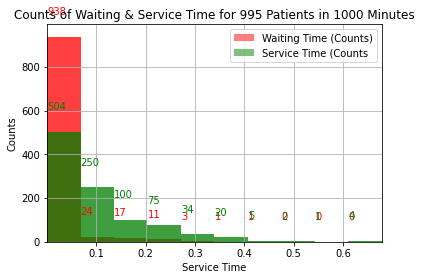




0.01068 [average wait]
0.01111 [expect wait]
0.109 [average customer in system]
0.111 [expect customer in system]

Confidence Interval to waitList:  (0.0107, 0.008, 0.0134)
Confidence Interval to serviceList:  (0.0981, 0.0919, 0.1043)
Confidence Interval to qnt_list:  (0.0976, 0.0779, 0.1173)





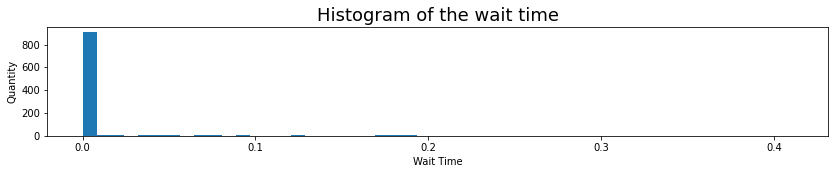

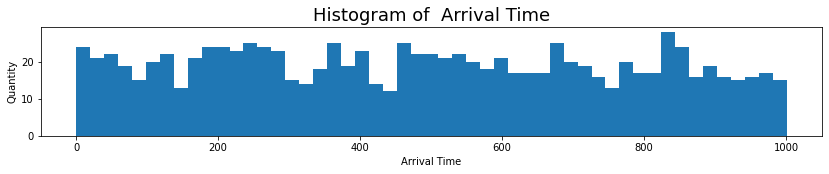

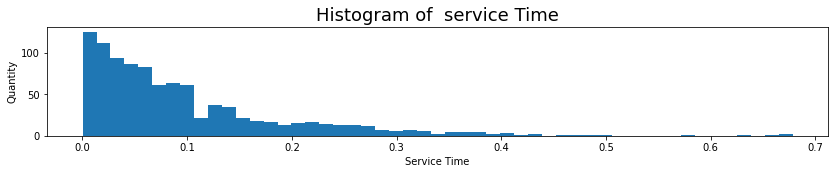

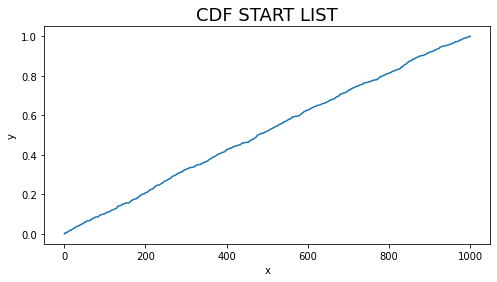

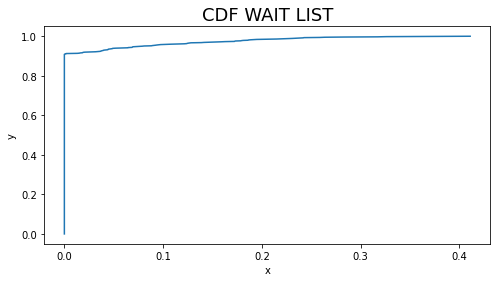

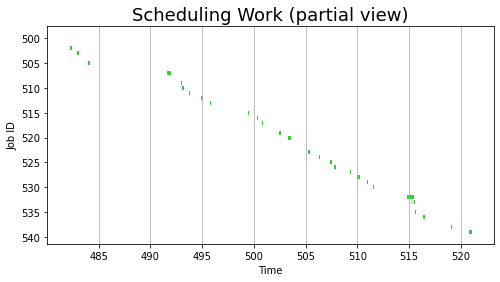

994
995
[0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(1000, 1, 10, 1,'m',1)
print(len(clientesSistemaList_1))
print(len(startList_1))
print(clientesSistemaList_1)

#### Questão 2

### Simulation: simT=1000, $\lambda$=2, $\mu$=20, $1/\lambda$=0.5, $1/\mu$=0.05, $\Qtd_de_Servidores$=1

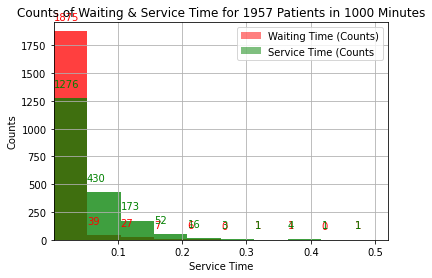




0.00638 [average wait]
0.00556 [expect wait]
0.113 [average customer in system]
0.111 [expect customer in system]

Confidence Interval to waitList:  (0.0064, 0.0051, 0.0077)
Confidence Interval to serviceList:  (0.0504, 0.0481, 0.0526)
Confidence Interval to qnt_list:  (0.115, 0.0982, 0.1319)





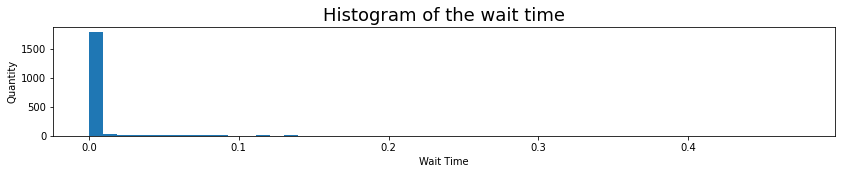

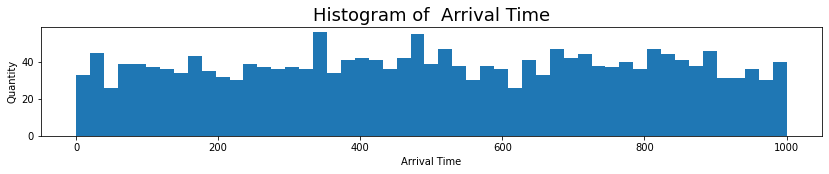

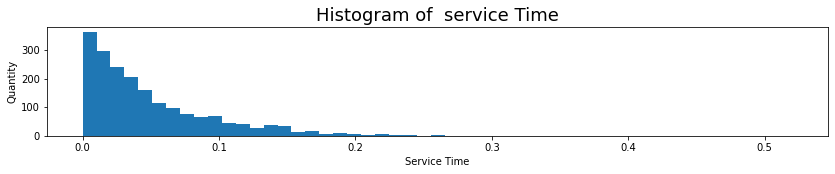

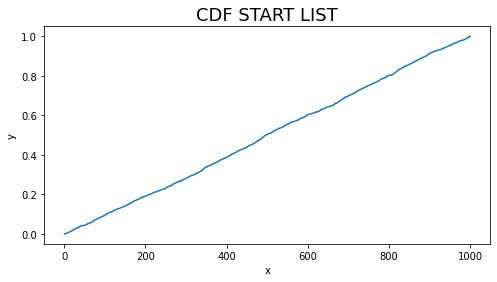

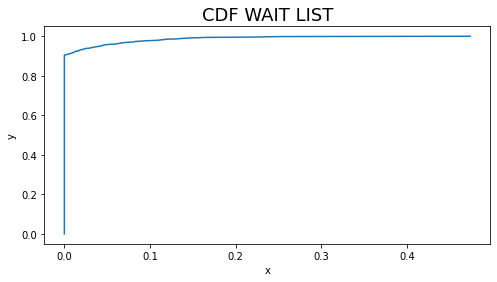

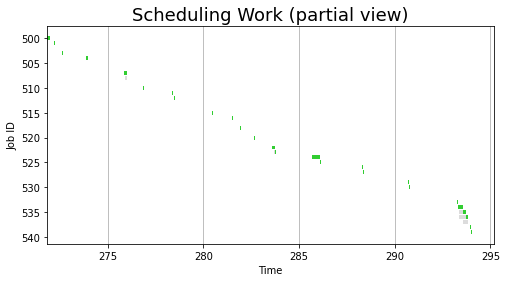

1956
1957
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
startList_2, arrivalList_2, response_List_2, serviceList_2, departureList_2, waitList_2, clientesSistemaList_2 = simulator(1000, 2, 20, 1,'m', 1)
print(len(clientesSistemaList_2))
print(len(startList_2))
print(clientesSistemaList_2)

#### Questão 3

### Simulation: simT=1000, $\lambda$=12, $\mu$=10, $1/\lambda$=0.08333333333333333, $1/\mu$=0.1, $\Qtd_de_Servidores$=1

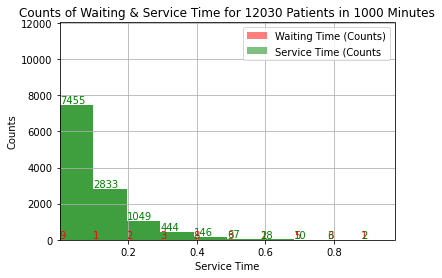




111.37747 [average wait]
-0.6 [expect wait]
1337.745 [average customer in system]
-6.0 [expect customer in system]

Confidence Interval to waitList:  (111.3775, 110.2974, 112.4576)
Confidence Interval to serviceList:  (0.1013, 0.0994, 0.1031)
Confidence Interval to qnt_list:  (1106.472, 1095.6725, 1117.2715)





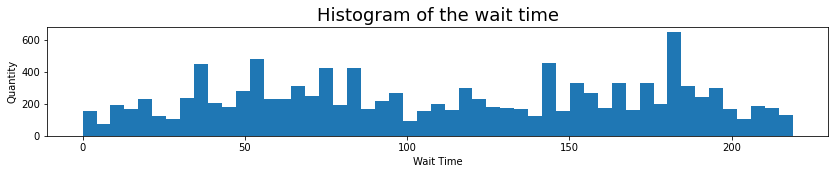

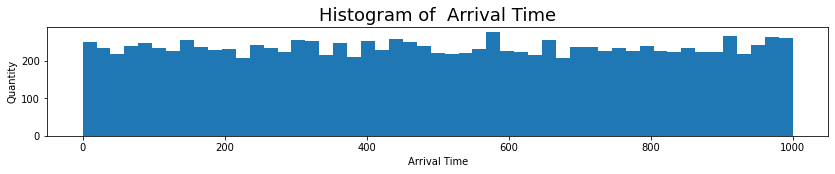

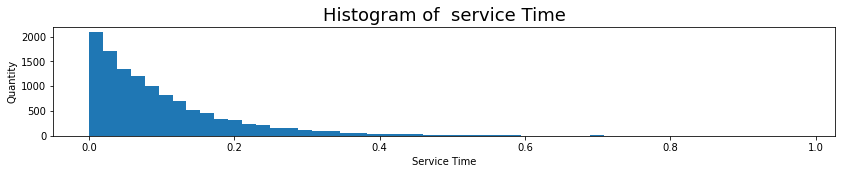

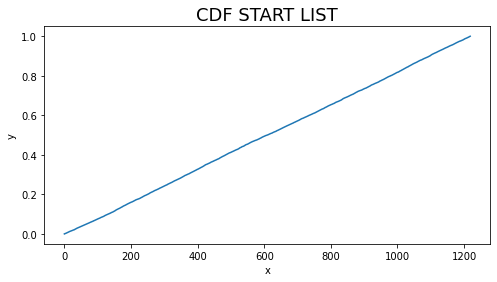

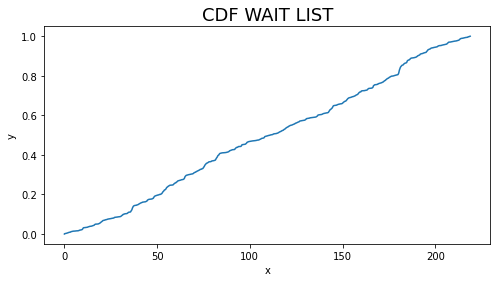

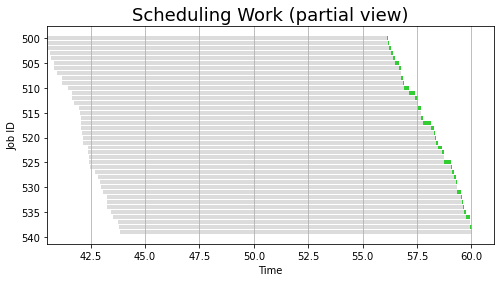

12029
12030
[0, 0, 0, 0, 1, 2, 1, 0, 0, 5, 6, 5, 5, 4, 3, 5, 5, 5, 4, 3, 3, 4, 5, 8, 10, 9, 8, 8, 9, 9, 8, 7, 11, 10, 11, 13, 15, 14, 14, 14, 15, 14, 18, 21, 20, 19, 22, 23, 22, 22, 22, 21, 20, 19, 18, 20, 19, 19, 23, 24, 23, 23, 23, 23, 27, 27, 27, 31, 33, 32, 31, 31, 30, 33, 32, 31, 31, 30, 31, 30, 29, 29, 30, 29, 28, 27, 26, 28, 28, 29, 28, 28, 29, 30, 29, 32, 37, 38, 38, 39, 38, 43, 45, 45, 44, 43, 43, 46, 45, 47, 48, 47, 47, 47, 46, 45, 44, 43, 42, 46, 45, 44, 43, 43, 48, 48, 47, 46, 45, 45, 44, 44, 44, 43, 42, 41, 40, 48, 51, 52, 51, 50, 51, 50, 53, 57, 59, 59, 58, 58, 58, 58, 59, 58, 58, 57, 57, 58, 61, 62, 65, 65, 67, 66, 69, 69, 74, 77, 80, 79, 79, 78, 79, 78, 77, 76, 77, 78, 79, 84, 85, 84, 83, 92, 92, 91, 90, 90, 93, 92, 92, 91, 90, 89, 92, 99, 98, 97, 96, 98, 98, 100, 99, 98, 99, 98, 97, 96, 97, 97, 96, 95, 94, 93, 93, 92, 92, 94, 94, 96, 97, 96, 95, 94, 93, 94, 99, 99, 104, 104, 104, 105, 105, 104, 104, 104, 105, 105, 104, 103, 103, 102, 104, 103, 103, 102, 102, 101, 108, 

In [ ]:
startList_3, arrivalList_3, response_List_3, serviceList_3, departureList_3, waitList_3, clientesSistemaList_3 = simulator(1000, 12, 10, 1,'m', 1)
print(len(clientesSistemaList_3))
print(len(startList_3))
print(clientesSistemaList_3)

#### Questão 4

### Simulation: simT=1000, $\lambda$=20, $\mu$=10, $1/\lambda$=0.05, $1/\mu$=0.1, $\Qtd_de_Servidores$=1

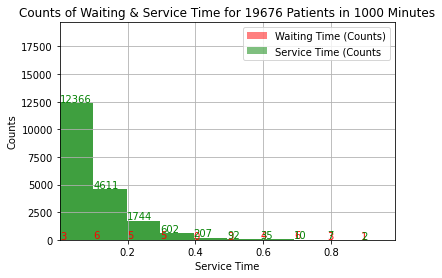




469.63351 [average wait]
-0.2 [expect wait]
9394.656 [average customer in system]
-2.0 [expect customer in system]

Confidence Interval to waitList:  (469.6335, 465.7458, 473.5212)
Confidence Interval to serviceList:  (0.0993, 0.0979, 0.1007)
Confidence Interval to qnt_list:  (4686.9618, 4648.7619, 4725.1618)





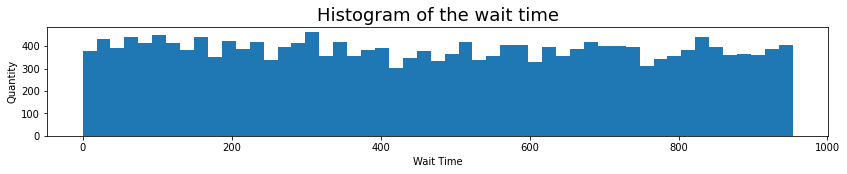

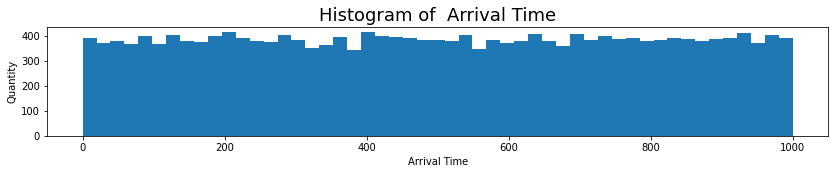

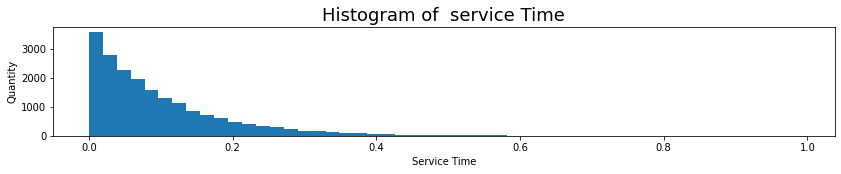

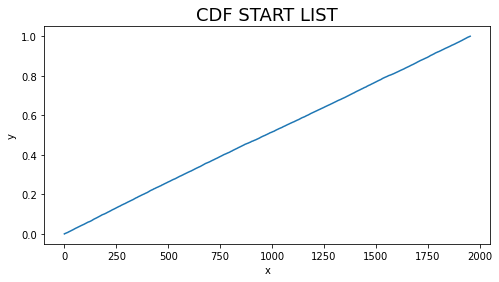

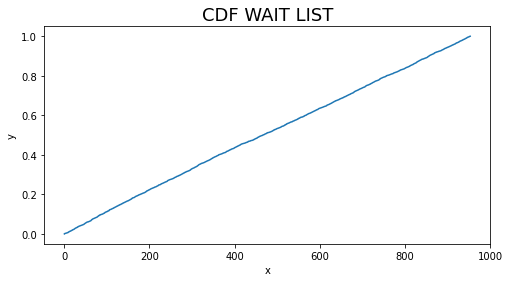

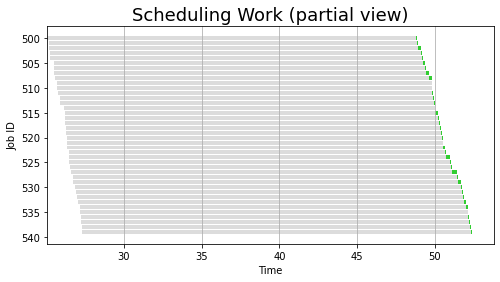

19675
19676
[0, 5, 6, 5, 4, 4, 4, 4, 3, 3, 4, 3, 5, 4, 4, 5, 7, 7, 10, 10, 10, 10, 13, 12, 12, 11, 13, 17, 16, 17, 18, 17, 16, 16, 18, 21, 28, 27, 29, 29, 28, 32, 32, 31, 30, 30, 29, 28, 45, 44, 50, 49, 50, 50, 51, 51, 52, 57, 58, 59, 59, 60, 66, 66, 65, 65, 64, 63, 64, 67, 72, 74, 77, 78, 82, 81, 85, 84, 85, 85, 84, 90, 91, 90, 90, 89, 88, 89, 90, 92, 95, 97, 98, 97, 96, 95, 95, 103, 108, 110, 115, 115, 115, 121, 121, 121, 125, 127, 126, 125, 129, 133, 133, 134, 135, 137, 140, 139, 142, 141, 142, 141, 152, 152, 154, 157, 158, 160, 169, 169, 169, 170, 169, 168, 170, 169, 168, 168, 171, 175, 175, 175, 174, 174, 174, 173, 173, 172, 172, 173, 178, 178, 181, 181, 182, 183, 183, 182, 183, 187, 186, 186, 186, 186, 185, 184, 183, 182, 181, 180, 179, 184, 183, 182, 181, 182, 185, 184, 183, 183, 183, 187, 187, 188, 187, 191, 194, 197, 201, 202, 203, 202, 202, 202, 202, 202, 204, 209, 209, 209, 209, 211, 211, 212, 211, 210, 216, 217, 221, 221, 220, 219, 218, 225, 225, 226, 225, 226, 227, 230, 23

In [ ]:
startList_4, arrivalList_4, response_List_4, serviceList_4, departureList_4, waitList_4, clientesSistemaList_4 = simulator(1000, 20, 10, 1,'m', 1)
print(len(clientesSistemaList_4))
print(len(startList_4))
print(clientesSistemaList_4)

#### Questão 5

### Simulation: simT=1000, $\lambda$=1, $\mu$=10, $1/\lambda$=1.0, $1/\mu$=0.1, $\Qtd_de_Servidores$=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.


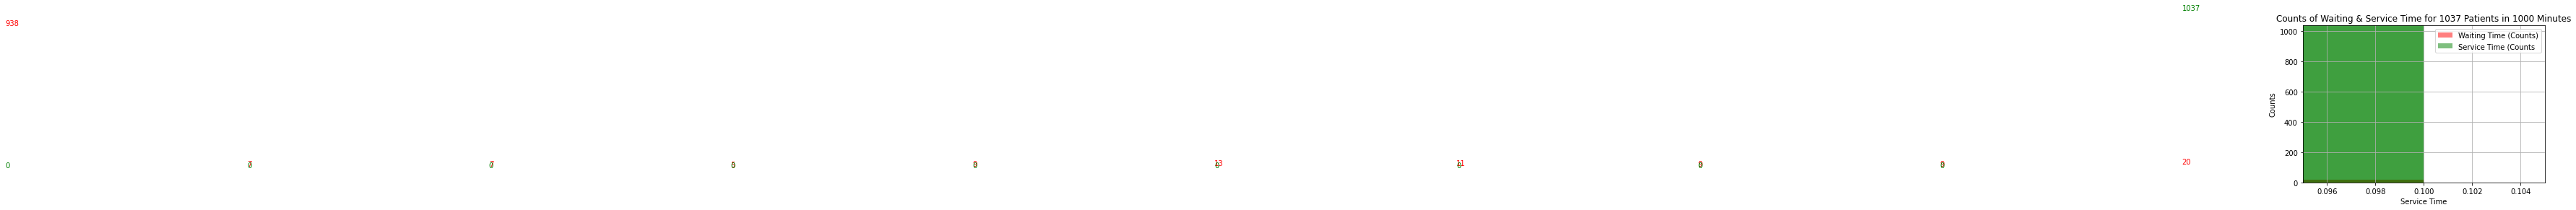




0.00672 [average wait]
0.01111 [expect wait]
0.107 [average customer in system]
0.111 [expect customer in system]

Confidence Interval to waitList:  (0.0067, 0.0053, 0.0081)
Confidence Interval to serviceList:  (0.1, 0.1, 0.1)
Confidence Interval to qnt_list:  (0.1139, 0.0926, 0.1352)





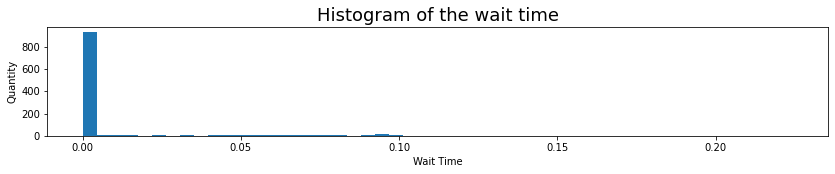

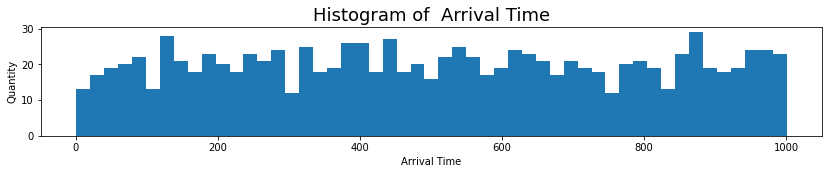

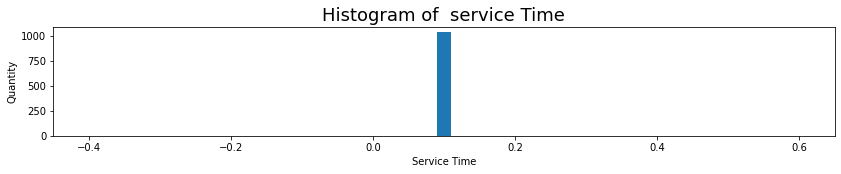

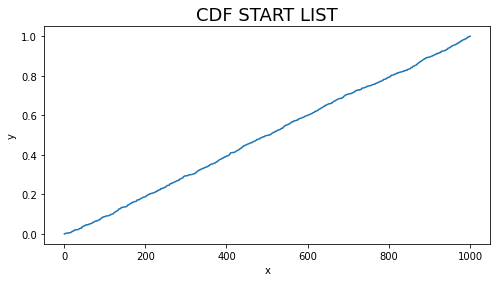

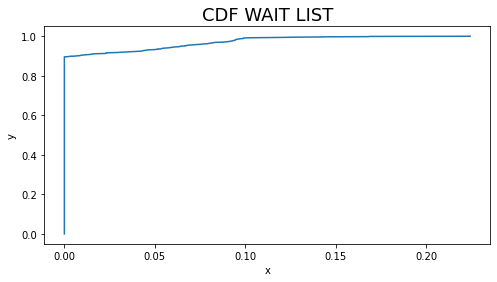

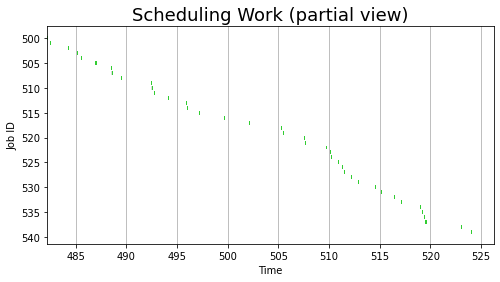

1036
1037
[0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
startList_5, arrivalList_5, response_List_5, serviceList_5, departureList_5, waitList_5, clientesSistemaList_5 = simulator(1000, 1, 10, 1,'d', 1)
print(len(clientesSistemaList_5))
print(len(startList_5))
print(clientesSistemaList_5)

#### Questão 6

### Simulation: simT=1000, $\lambda$=2, $\mu$=20, $1/\lambda$=0.5, $1/\mu$=0.05, $\Qtd_de_Servidores$=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Attempting to set identical left == right == 0.05 results in singular transformations; automatically expanding.


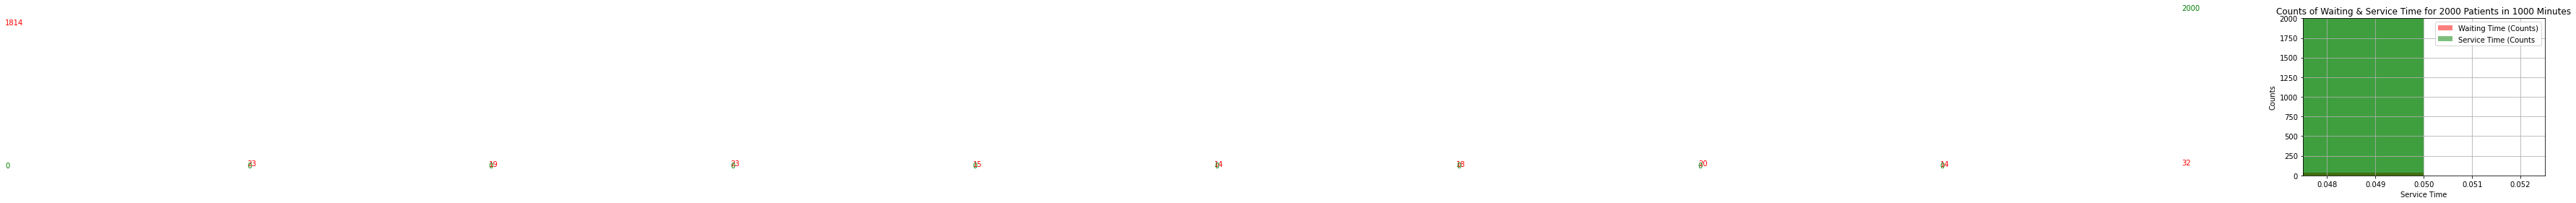




0.00277 [average wait]
0.00556 [expect wait]
0.106 [average customer in system]
0.111 [expect customer in system]

Confidence Interval to waitList:  (0.0028, 0.0023, 0.0032)
Confidence Interval to serviceList:  (0.05, 0.05, 0.05)
Confidence Interval to qnt_list:  (0.1066, 0.0925, 0.1206)





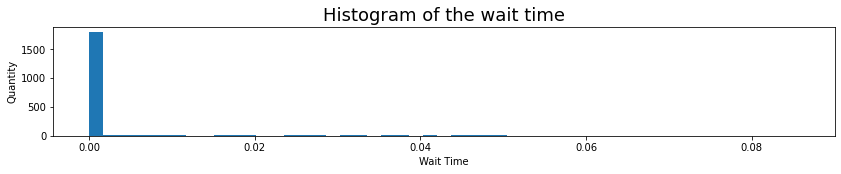

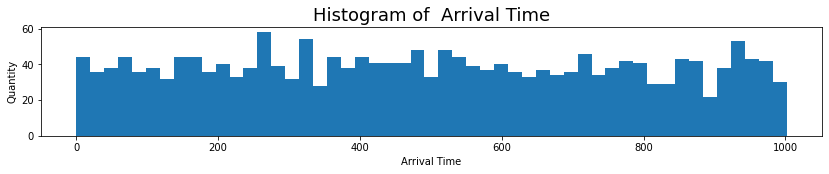

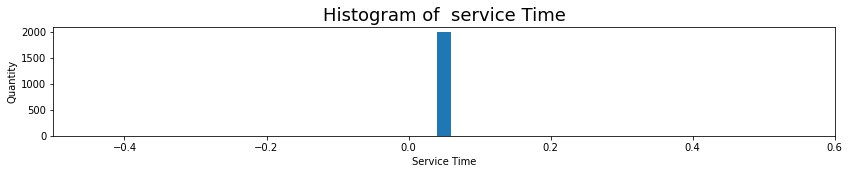

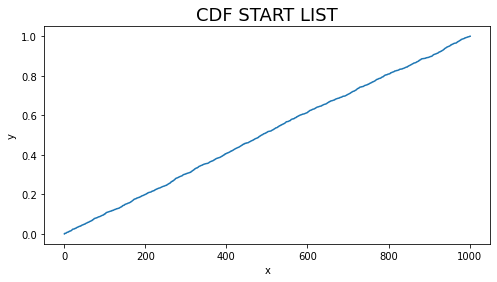

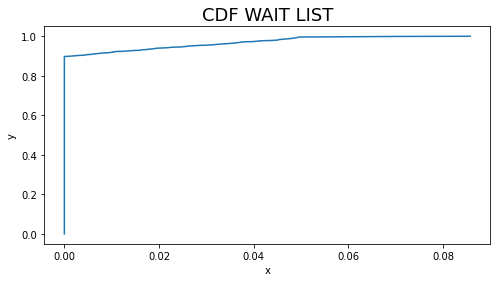

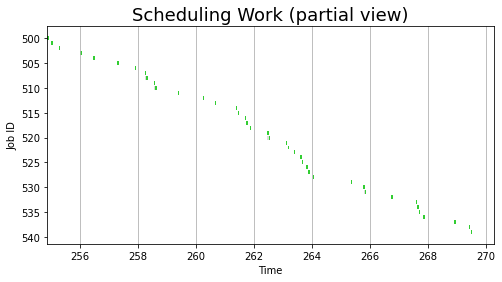

1999
2000
[0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [ ]:
startList_6, arrivalList_6, response_List_6, serviceList_6, departureList_6, waitList_6, clientesSistemaList_6 = simulator(1000, 2, 20, 1,'d', 1)
print(len(clientesSistemaList_6))
print(len(startList_6))
print(clientesSistemaList_6)

#### Questão 7

### Simulation: simT=1000, $\lambda$=12, $\mu$=10, $1/\lambda$=0.08333333333333333, $1/\mu$=0.1, $\Qtd_de_Servidores$=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.


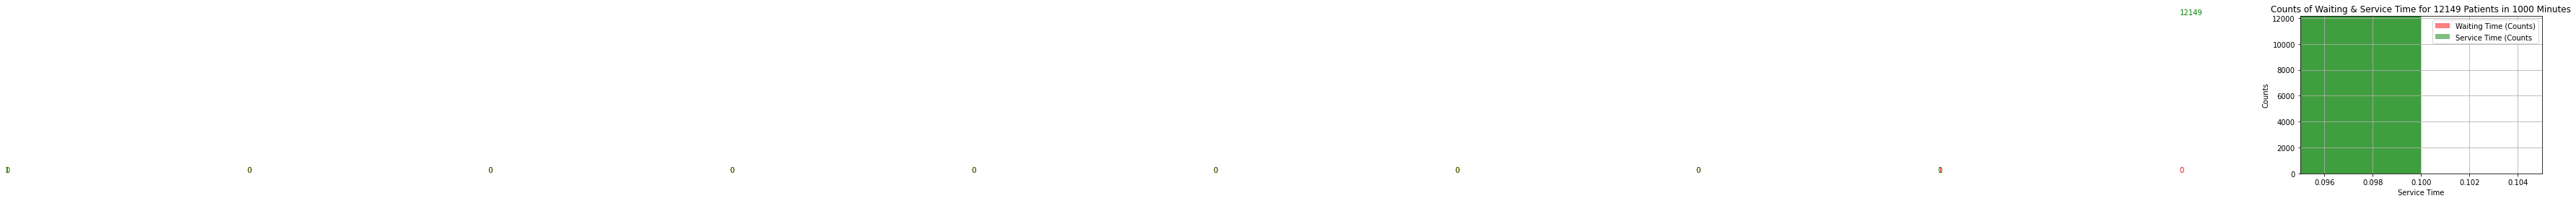




103.74601 [average wait]
-0.6 [expect wait]
1246.152 [average customer in system]
-6.0 [expect customer in system]

Confidence Interval to waitList:  (103.746, 102.6435, 104.8485)
Confidence Interval to serviceList:  (0.1, 0.1, 0.1)
Confidence Interval to qnt_list:  (1038.0485, 1027.0237, 1049.0733)





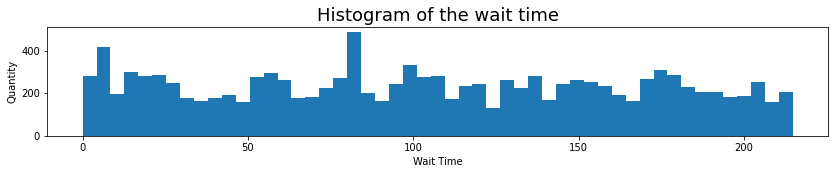

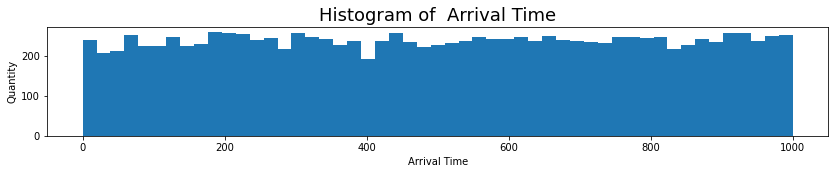

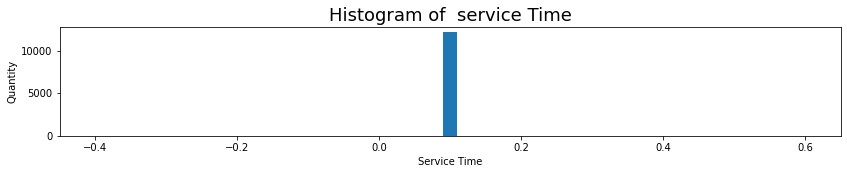

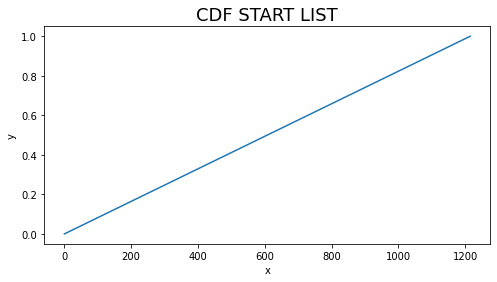

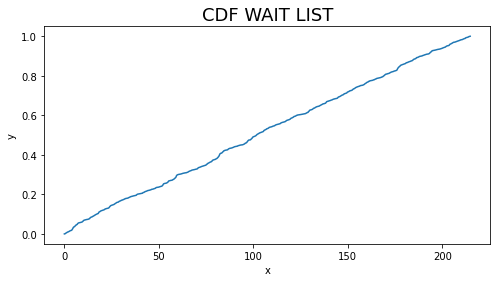

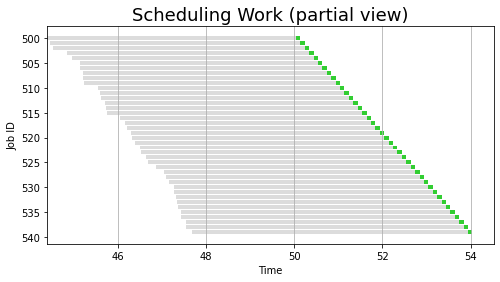

12148
12149
[4, 3, 4, 4, 3, 4, 4, 4, 6, 7, 6, 6, 9, 9, 9, 9, 8, 9, 8, 9, 8, 7, 8, 9, 9, 11, 12, 15, 16, 16, 16, 15, 15, 14, 13, 13, 13, 12, 12, 11, 10, 9, 8, 7, 6, 5, 4, 6, 6, 5, 5, 5, 6, 5, 6, 8, 7, 6, 6, 7, 6, 5, 6, 6, 8, 9, 10, 10, 9, 8, 12, 12, 13, 15, 14, 15, 14, 13, 12, 15, 16, 16, 16, 16, 16, 15, 14, 15, 15, 14, 14, 14, 13, 12, 14, 14, 14, 14, 17, 19, 20, 20, 20, 20, 21, 21, 21, 24, 23, 24, 23, 24, 24, 25, 24, 23, 22, 22, 22, 24, 23, 24, 24, 24, 24, 25, 25, 25, 24, 26, 28, 30, 29, 30, 29, 28, 28, 27, 27, 28, 27, 29, 29, 28, 30, 31, 32, 32, 31, 31, 31, 30, 30, 29, 28, 29, 28, 30, 30, 29, 30, 29, 30, 29, 29, 29, 29, 30, 33, 33, 33, 35, 39, 40, 41, 42, 42, 42, 41, 42, 43, 43, 42, 43, 45, 46, 46, 45, 44, 44, 43, 44, 44, 43, 44, 44, 44, 45, 44, 46, 45, 46, 46, 45, 44, 46, 45, 44, 44, 43, 43, 43, 42, 43, 44, 44, 43, 42, 41, 41, 40, 42, 44, 43, 43, 43, 43, 42, 41, 40, 39, 38, 39, 40, 39, 40, 39, 39, 40, 39, 38, 37, 39, 39, 39, 38, 39, 40, 40, 39, 38, 39, 40, 40, 42, 44, 44, 44, 47, 46,

In [ ]:
startList_7, arrivalList_7, response_List_7, serviceList_7, departureList_7, waitList_7, clientesSistemaList_7 = simulator(1000, 12, 10, 1,'d', 1)
print(len(clientesSistemaList_7))
print(len(startList_7))
print(clientesSistemaList_7)

#### Questão 8

### Simulation: simT=1000, $\lambda$=20, $\mu$=10, $1/\lambda$=0.05, $1/\mu$=0.1, $\Qtd_de_Servidores$=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.


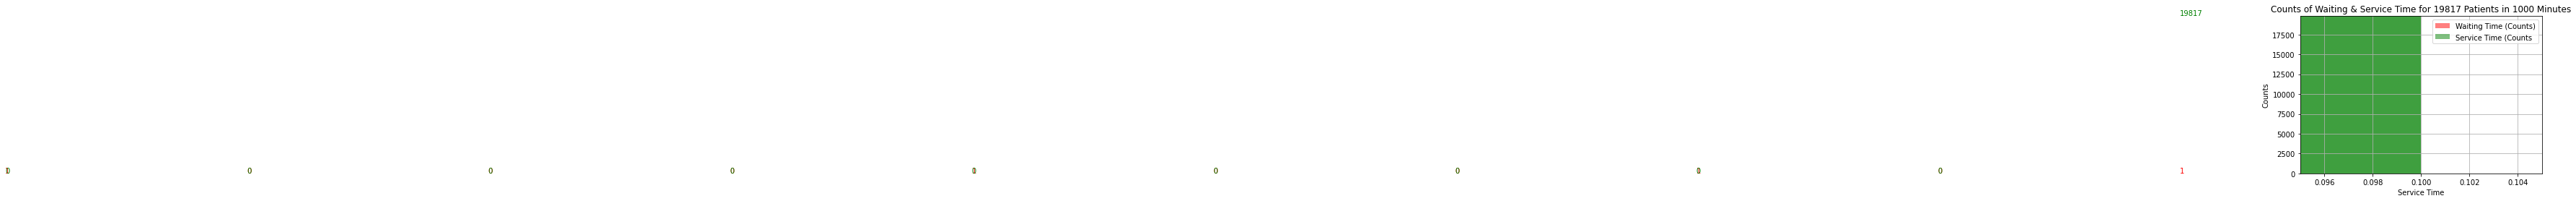




494.10547 [average wait]
-0.2 [expect wait]
9884.109 [average customer in system]
-2.0 [expect customer in system]

Confidence Interval to waitList:  (494.1055, 490.1785, 498.0325)
Confidence Interval to serviceList:  (0.1, 0.1, 0.1)
Confidence Interval to qnt_list:  (4941.8066, 4902.5375, 4981.0758)





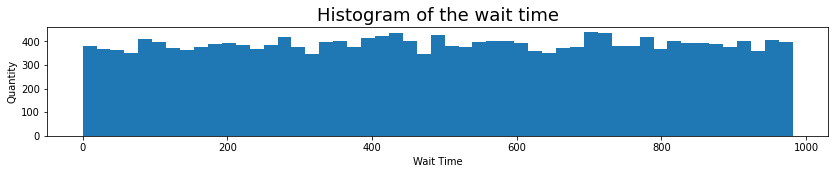

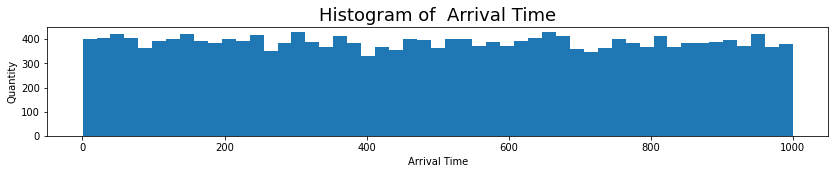

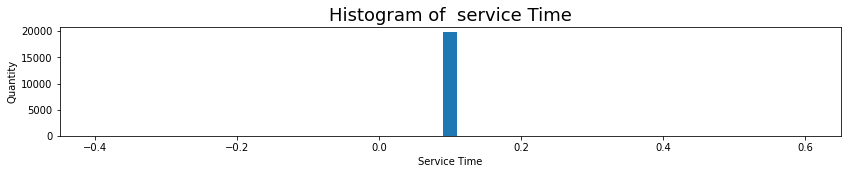

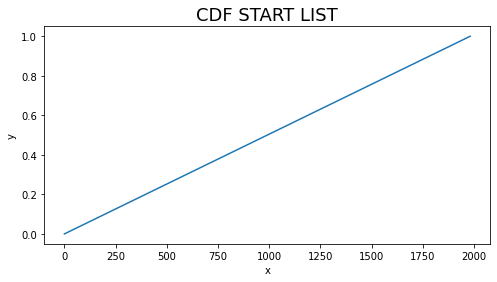

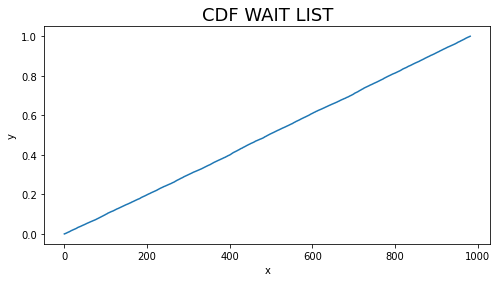

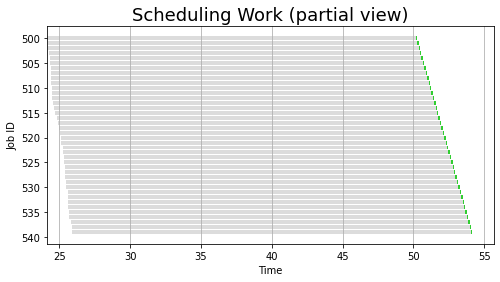

19816
19817
[1, 1, 3, 3, 4, 4, 8, 13, 13, 14, 15, 16, 20, 23, 24, 25, 28, 29, 30, 33, 37, 38, 38, 39, 43, 46, 46, 46, 46, 46, 47, 47, 49, 51, 53, 53, 56, 60, 60, 62, 62, 64, 65, 65, 65, 65, 64, 64, 64, 66, 67, 67, 67, 68, 68, 70, 70, 72, 73, 73, 78, 77, 77, 82, 81, 82, 82, 83, 87, 88, 87, 86, 86, 86, 87, 91, 92, 93, 94, 94, 96, 95, 95, 97, 99, 100, 100, 101, 101, 103, 107, 108, 113, 117, 116, 118, 120, 121, 123, 123, 122, 123, 124, 126, 126, 127, 129, 129, 128, 127, 128, 130, 131, 133, 133, 134, 136, 138, 142, 142, 142, 145, 146, 150, 150, 152, 155, 154, 155, 154, 155, 155, 155, 155, 158, 158, 160, 159, 159, 159, 158, 157, 157, 161, 160, 161, 160, 160, 160, 159, 159, 162, 162, 162, 162, 162, 163, 163, 165, 165, 170, 174, 174, 174, 176, 177, 178, 178, 182, 183, 184, 183, 184, 185, 186, 187, 187, 189, 190, 191, 193, 192, 193, 192, 192, 192, 196, 198, 200, 202, 204, 204, 203, 203, 204, 207, 209, 210, 210, 210, 210, 212, 212, 215, 215, 218, 220, 219, 221, 222, 222, 224, 229, 230, 231, 232,

In [ ]:
startList_8, arrivalList_8, response_List_8, serviceList_8, departureList_8, waitList_8, clientesSistemaList_8 = simulator(1000, 20, 10, 1,'d', 1)
print(len(clientesSistemaList_8))
print(len(startList_8))
print(clientesSistemaList_8)

### Tópico 4.1

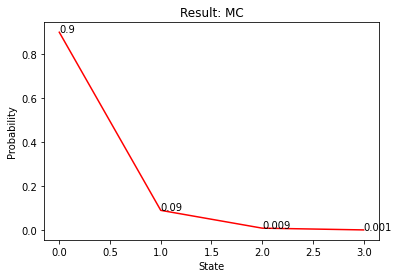

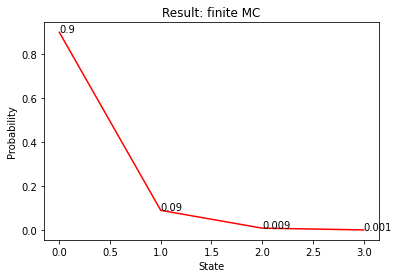

In [ ]:
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_2 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_3 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_4 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_5 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_6 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_7 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_8 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_9 = simulator(5000, 1, 10, 1,'m',0)
startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_10 = simulator(5000, 1, 10, 1,'m',0)

lista1 = calc1(clientesSistemaList_1,0)
lista2 = calc1(clientesSistemaList_2,0)
lista3 = calc1(clientesSistemaList_3,0)
lista4 = calc1(clientesSistemaList_4,0)
lista5 = calc1(clientesSistemaList_5,0)
lista6 = calc1(clientesSistemaList_6,0)
lista7 = calc1(clientesSistemaList_7,0)
lista8 = calc1(clientesSistemaList_8,0)
lista9 = calc1(clientesSistemaList_9,0)
lista10 = calc1(clientesSistemaList_10,0)

lista_resl = []
lista_res = []
lista_resh = []
for i in range(0, len(lista1)):
  (a,b,c) = confidence_interval([lista1[i],lista2[i],lista3[i],lista4[i],lista5[i],lista6[i],lista7[i],lista8[i],lista9[i],lista10[i]])
  lista_res.append(a)
  lista_resl.append(b)
  lista_resh.append(c)
calc2(list(set(clientesSistemaList_1)), 1/10)

calc3(list(set(clientesSistemaList_1)),1,10,1)


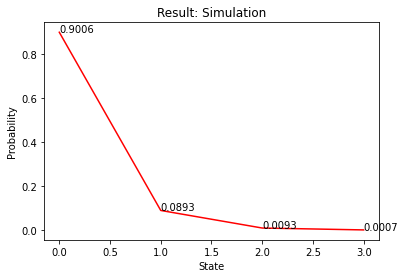

0 0.8964 0.9048
1 0.0856 0.093
2 0.0082 0.0104
3 0.0004 0.001


In [ ]:
x = list(set(clientesSistemaList_1))
# plt.plot(x,lista_resl, color='blue')
plt.plot(x,lista_res, color='red')
# plt.plot(x,lista_resh, color='blue')
plt.title("Result: Simulation")
plt.xlabel("State")
plt.ylabel("Probability")
# for a,b in zip(x, lista_resl): 
#   plt.text(a, b, str(b))
for a,b in zip(x, lista_res): 
  plt.text(a, b, str(round(b*10000)/10000))
# for a,b in zip(x, lista_resh): 
#   plt.text(a, b, str(b))
plt.show()
for i in range(0,len(x)):
  print(i,round(lista_resl[i]*10000)/10000,round(lista_resh[i]*10000)/10000)

### Tópico 4.2


## Topico 5

### Questão 5.1

#### Construindo a Heuristica

In [ ]:
def plot_histogram(data, title, xlabel):
      plt.figure(figsize=(6, 4))
      plt.title(title, size=18)
      plt.xlabel(xlabel)
      plt.ylabel("Quantity")
      plt.hist(data, bins=51)
      plt.show()

In [ ]:
import pandas as pd
def connect_graphs(startList, arrivalList, departureList):
  #df = pd.DataFrame()
  #df['Arrival Time'] = arrivalList
  #df['Start Time'] = startList
  #df['Departure Time'] = departureList
  #display(df.head(10))
  dict = {} # principal dict
  finalList = [] # final list to verify 
  exitGradeList = [] # List of Exit grades 
  listNode = [] # list with all the nodes in this interaction
  max_key = 0 # Max key to put in the dict key
  len_key = 0 # How bigger is the max key
  max_value_node = 0 # max value node to verify if we pass for all the nodes in tree
  flag = False

# Loop in the shape of start list
  for i in range(len(startList)):
    flag = False # define flag of addiction like false
    arrivalTime_Atual = arrivalList[i] # verify the actual arrival time
    departureAtual = departureList[i] # verify the actual departure time
    
    lista_arrival = [x for x in range(i+1,len(startList)) if arrivalList[x] < departureAtual]
    # Loop in the nodes after the actual node
    for j in lista_arrival : 
        x = [item for item in finalList if j in item] # verify if this element are in the actual tree
        if len(x) == 0: # if the answer of the last question is not
          node = (i,j) # create a node
          listNode.append(node) # add node in the lista of nodes in this interaction
          finalList.append(node) # add in the final list to validation 
          if j > max_value_node: # verify if we have a new max value
                max_value_node = j # set the actual max_value_node
          flag = True # set flag for add in dict like tru
    
    # Verify if didnt have a new node in a list and the list has more than one node or the listNode is infinite
    if (flag == False and len(listNode) > 0 and max_value_node == i):
      dict[listNode[0][0]] = listNode # put the list in dictionary
      exitGradeList.append(len(listNode)) # append the exit grade in the list
      # Verify if there are a new max key in this listNode
      if len(listNode) > len_key:
        max_key = listNode[0][0] # actualize max_key to select a bigger tree
        len_key = len(listNode) # actualize len key
      listNode = [] # clena the listNode to init a new tree
      max_value_node = 0 # actualize the valur to put in the dict
    
    # verify if we have a tree only with a root
    elif flag == False and len(listNode) == 0:
      dict[i] = listNode # put the list in dictionary
      exitGradeList.append(len(listNode)) # append the exit grade in the list
    
  return dict, exitGradeList

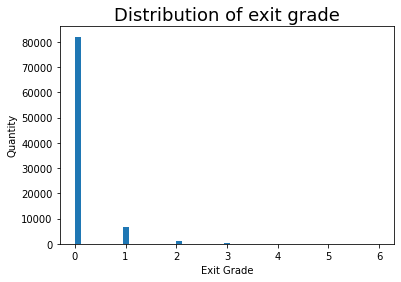

In [ ]:
lista =[]
lista_dict = []
for i in range(100):
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(1000, 1, 10, 1,'m',0)
    path, exitGradeList = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")

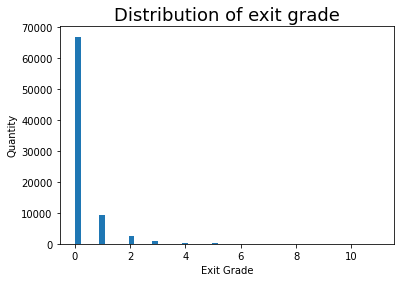

In [ ]:
lista =[]
lista_dict = []
for i in range(100):
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(1000, 1, 5, 1,'m',0)
    path, exitGradeList = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")

  >> Valor de i : 0
  >> Valor de i : 10
  >> Valor de i : 20
  >> Valor de i : 30
  >> Valor de i : 40
  >> Valor de i : 50
  >> Valor de i : 60
  >> Valor de i : 70
  >> Valor de i : 80
  >> Valor de i : 90


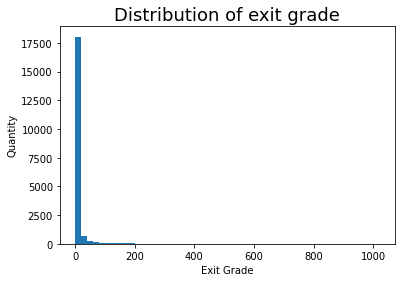

In [ ]:
lista =[]
lista_dict = []
for i in range(100):
    if i % 10 == 0:
      print("  >> Valor de i :", i)
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(200, 9, 10, 1,'m',0)
    path, exitGradeList = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")

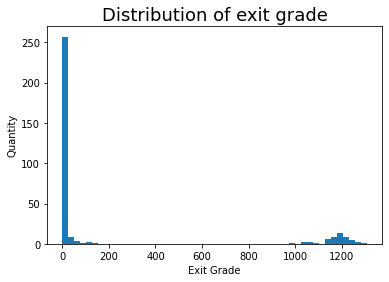

In [ ]:
lista =[]
lista_dict = []
for i in range(50):
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(100, 12, 10, 1,'m',0)
    path, exitGradeList = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")

  >> Valor de i : 0
  >> Valor de i : 3
  >> Valor de i : 6
  >> Valor de i : 9


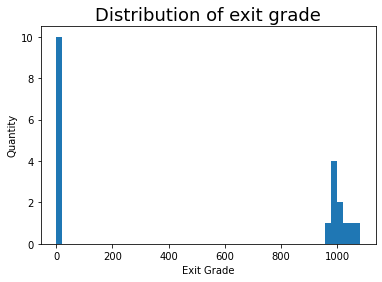

In [ ]:
lista =[]
lista_dict = []
for i in range(10):
    if i % 3 == 0:
      print("  >> Valor de i :", i)
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(50, 20, 10, 1,'m',0)
    path, exitGradeList = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")

#### Heuristica Utilizada 

Dessa forma, vamos assumir que sempre que uma arvore passar de 300 nós, vamos considerar ela como infinita, pois como visto nos graficos e casos testado anteriormente, vemos que temos casos que terminam até 200 nós e outros que só terminam com o programa quando assumem 1000 nós 

#### Probabilidades de cada caso 

In [ ]:
import pandas as pd
def connect_graphs(startList, arrivalList, departureList):
  #df = pd.DataFrame()
  #df['Arrival Time'] = arrivalList
  #df['Start Time'] = startList
  #df['Departure Time'] = departureList
  #display(df.head(10))
  qtd_finitas = 0 # Quantity of finite trees
  qtd_infinitas = 0 # quantity of infinitys trees
  dict = {} # principal dict
  finalList = [] # final list to verify 
  exitGradeList = [] # List of Exit grades 
  listNode = [] # list with all the nodes in this interaction
  max_key = 0 # Max key to put in the dict key
  len_key = 0 # How bigger is the max key
  max_value_node = 0 # max value node to verify if we pass for all the nodes in tree
  flag = False

# Loop in the shape of start list
  for i in range(len(startList)):
    flag = False # define flag of addiction like false
    arrivalTime_Atual = arrivalList[i] # verify the actual arrival time
    departureAtual = departureList[i] # verify the actual departure time
    
    lista_arrival = [x for x in range(i+1,len(startList)) if arrivalList[x] < departureAtual]
    # Loop in the nodes after the actual node
    for j in lista_arrival : 
        x = [item for item in finalList if j in item] # verify if this element are in the actual tree
        if len(x) == 0: # if the answer of the last question is not
          node = (i,j) # create a node
          listNode.append(node) # add node in the lista of nodes in this interaction
          finalList.append(node) # add in the final list to validation 
          if j > max_value_node: # verify if we have a new max value
                max_value_node = j # set the actual max_value_node
          flag = True # set flag for add in dict like tru
        if len(listNode) == 400: # verify if we are in a infinite tree
          break # stop the loop
    # Verify if didnt have a new node in a list and the list has more than one node or the listNode is infinite
    if (flag == False and len(listNode) > 0 and max_value_node == i) or len(listNode) == 400:
      dict[listNode[0][0]] = listNode # put the list in dictionary
      exitGradeList.append(len(listNode)) # append the exit grade in the list
      # Verify if there are a new max key in this listNode
      if len(listNode) > len_key:
        max_key = listNode[0][0] # actualize max_key to select a bigger tree
        len_key = len(listNode) # actualize len key
      if len(listNode) == 400:
        qtd_infinitas = qtd_infinitas +1 # increment ind=finites
      else:
        qtd_finitas = qtd_finitas +1 # increment finites elements
      listNode = [] # clena the listNode to init a new tree
      max_value_node = 0 # actualize the valur to put in the dict
    
    # verify if we have a tree only with a root
    elif flag == False and len(listNode) == 0:
      dict[i] = listNode # put the list in dictionary
      exitGradeList.append(len(listNode)) # append the exit grade in the list
      qtd_finitas = qtd_finitas +1
    
  return dict, exitGradeList, qtd_finitas, qtd_infinitas


Prob ser infinita:  0.0




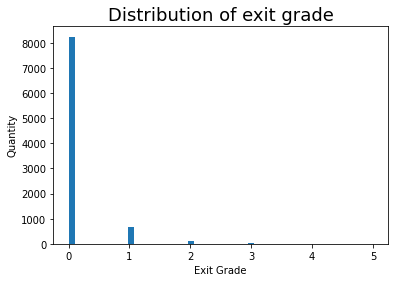

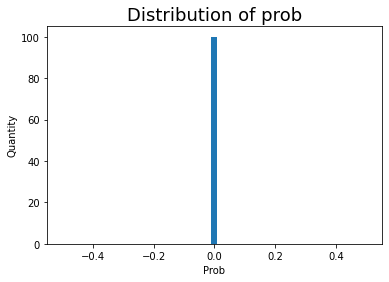

In [ ]:
lista =[]
lista_dict = []
lista_proporcao = []
finitas_total = 0
infinitas_total = 0
for i in range(100):
    #if i % 3 == 0:
    #  print("  >> Valor de i :", i)
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(100, 1, 10, 1,'m',0)
    path, exitGradeList, qtd_finitas, qtd_infinitas = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)
    lista_proporcao.append(qtd_infinitas/((qtd_infinitas+qtd_finitas)*1.0))
    finitas_total= finitas_total + qtd_finitas
    infinitas_total= infinitas_total + qtd_infinitas

print("\nProb ser infinita: ", infinitas_total/((infinitas_total+finitas_total)*1.0))

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
print("\n")
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")
print("\n")
plot_histogram(lista_proporcao, "Distribution of prob", "Prob")


Prob ser infinita:  0.0




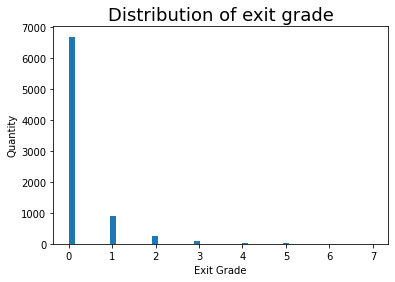

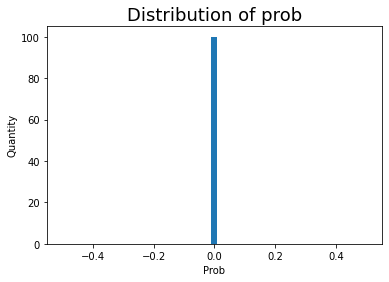

In [ ]:
lista =[]
lista_dict = []
lista_proporcao = []
finitas_total = 0
infinitas_total = 0
for i in range(100):
    #if i % 3 == 0:
    #  print("  >> Valor de i :", i)
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(100, 1, 5, 1,'m',0)
    path, exitGradeList, qtd_finitas, qtd_infinitas = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)
    lista_proporcao.append(qtd_infinitas/((qtd_infinitas+qtd_finitas)*1.0))
    finitas_total= finitas_total + qtd_finitas
    infinitas_total= infinitas_total + qtd_infinitas

print("\nProb ser infinita: ", infinitas_total/((infinitas_total+finitas_total)*1.0))

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
print("\n")
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")
print("\n")
plot_histogram(lista_proporcao, "Distribution of prob", "Prob")


Prob ser infinita:  0.0010086746015735323




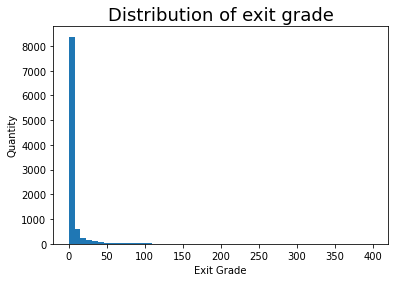

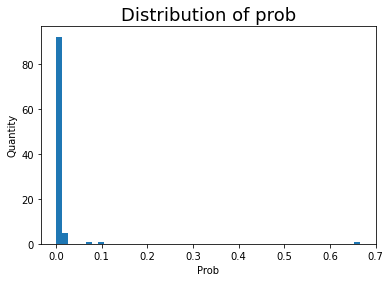

In [ ]:
lista =[]
lista_dict = []
lista_proporcao = []
finitas_total = 0
infinitas_total = 0
for i in range(100):
    #if i % 3 == 0:
    #  print("  >> Valor de i :", i)
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(100, 9, 10, 1,'m',0)
    path, exitGradeList, qtd_finitas, qtd_infinitas = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)
    lista_proporcao.append(qtd_infinitas/((qtd_infinitas+qtd_finitas)*1.0))
    finitas_total= finitas_total + qtd_finitas
    infinitas_total= infinitas_total + qtd_infinitas

print("\nProb ser infinita: ", infinitas_total/((infinitas_total+finitas_total)*1.0))

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
print("\n")
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")
print("\n")
plot_histogram(lista_proporcao, "Distribution of prob", "Prob")


Prob ser infinita:  0.20157068062827224




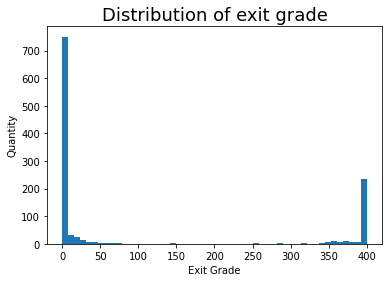

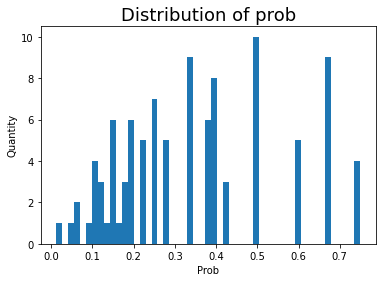

In [ ]:
lista =[]
lista_dict = []
lista_proporcao = []
finitas_total = 0
infinitas_total = 0
for i in range(100):
    #if i % 3 == 0:
    #  print("  >> Valor de i :", i)
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(100, 12, 10, 1,'m',0)
    path, exitGradeList, qtd_finitas, qtd_infinitas = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)
    lista_proporcao.append(qtd_infinitas/((qtd_infinitas+qtd_finitas)*1.0))
    finitas_total= finitas_total + qtd_finitas
    infinitas_total= infinitas_total + qtd_infinitas

print("\nProb ser infinita: ", infinitas_total/((infinitas_total+finitas_total)*1.0))

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
print("\n")
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")
print("\n")
plot_histogram(lista_proporcao, "Distribution of prob", "Prob")


Prob ser infinita:  0.46511627906976744




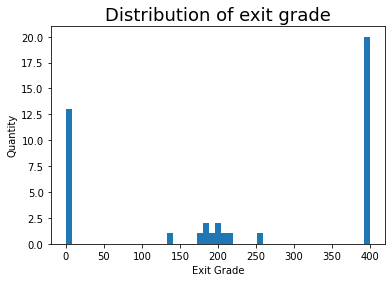

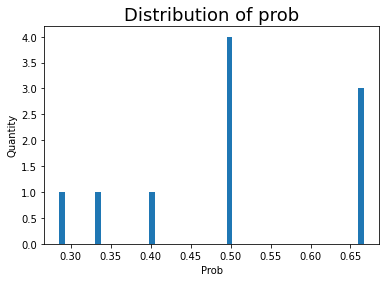

In [ ]:
lista =[]
lista_dict = []
lista_proporcao = []
finitas_total = 0
infinitas_total = 0
for i in range(10):
    #if i % 3 == 0:
    #  print("  >> Valor de i :", i)
    startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(50, 20, 10, 1,'m',0)
    path, exitGradeList, qtd_finitas, qtd_infinitas = connect_graphs(startList_1, arrivalList_1, departureList_1)
    lista.append(exitGradeList)
    lista_dict.append(path)
    lista_proporcao.append(qtd_infinitas/((qtd_infinitas+qtd_finitas)*1.0))
    finitas_total= finitas_total + qtd_finitas
    infinitas_total= infinitas_total + qtd_infinitas

print("\nProb ser infinita: ", infinitas_total/((infinitas_total+finitas_total)*1.0))

lista_final = []
for i in lista:
    for j in i:
        lista_final.append(j)
print("\n")
plot_histogram(lista_final, "Distribution of exit grade", "Exit Grade")
print("\n")
plot_histogram(lista_proporcao, "Distribution of prob", "Prob")

### Questão 5.2

In [ ]:
def connect_graphs(startList, arrivalList, departureList):
  qtd_finitas = 0 # Quantity of finite trees
  qtd_infinitas = 0 # quantity of infinitys trees
  dict = {} # principal dict
  finalList = [] # final list to verify 
  exitGradeList = [] # List of Exit grades 
  listNode = [] # list with all the nodes in this interaction
  max_key = 0 # Max key to put in the dict key
  len_key = 0 # How bigger is the max key
  max_value_node = 0 # max value node to verify if we pass for all the nodes in tree

# Loop in the shape of start list
  for i in range(len(startList)):
    flag = False # define flag of addiction like false
    arrivalTime_Atual = arrivalList[i] # verify the actual arrival time
    departureAtual = departureList[i] # verify the actual departure time
    
    # Loop in the nodes after the actual node
    for j in range(i+1,len(startList)): 
      # verify if the arrival time is less than actual departure time or it is a son of the root
      if arrivalList[j] < departureAtual:
        x = [item for item in finalList if j in item] # verify if this element are in the actual tree
        if len(x) == 0: # if the answer of the last question is not
          node = (i,j) # create a node
          listNode.append(node) # add node in the lista of nodes in this interaction
          finalList.append(node) # add in the final list to validation 
          if j > max_value_node: # verify if we have a new max value
                max_value_node = j # set the actual max_value_node
          flag = True # set flag for add in dict like true
      if len(listNode) == 300: # verify if we are in a infinite tree
            break # stop the loop
            
    # Verify if didnt have a new node in a list and the list has more than one node or the listNode is infinite
    if (flag == False and len(listNode) > 0 and max_value_node == i) or len(listNode) == 300: 
      dict[listNode[0][0]] = listNode # put the list in dictionary
      exitGradeList.append(len(listNode)) # append the exit grade in the list
      # Verify if there are a new max key in this listNode
      if len(listNode) > len_key:
        max_key = listNode[0][0] # actualize max_key to select a bigger tree
        len_key = len(listNode) # actualize len key
      if len(listNode) == 300:
        qtd_infinitas = qtd_infinitas +1 # increment ind=finites
      else:
        qtd_finitas = qtd_finitas +1 # increment finites elements
      listNode = [] # clena the listNode to init a new tree
      max_value_node = 0 # actualize the valur to put in the dict
    
    # verify if we have a tree only with a root
    elif flag == False and len(listNode) == 0:
      dict[i] = listNode # put the list in dictionary
      exitGradeList.append(len(listNode)) # append the exit grade in the list
      qtd_finitas = qtd_finitas +1 # increment finites elements

    
  print("\nQtd de arvores finitas: ", qtd_finitas)
  print("Qtd de arvores infinitas: ", qtd_infinitas)
  # Confidence Interval
  def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m-h, m+h)

  def mean_exit_grade_root(dict):
    rootSum = 0
    listNode_rootSum = []
    #print(dict.keys())
    for i in dict.keys():
      x = [item for item in dict[i] if i in item]
      #print("    >> " + str(x) + " - " + str(len(x)))
      rootSum = rootSum + len(x)
      listNode_rootSum.append(len(x))
    return rootSum/float(len(dict)), listNode_rootSum

  mean_exit_grade_root, listNode_rootSum = mean_exit_grade_root(dict)
  print("\nmean_exit_grade_root: ", mean_exit_grade_root)
  print("Confidence Interval: ",confidence_interval(listNode_rootSum))

  def mean_max_exit_grade(dict):
    maxGradeSum = 0
    maxGradeSum_list = []
    height = 0
    height_list = []
    height_node = 0
    height_node_list = []

    for i in dict.keys():
      x = [item[0] for item in dict[i]]
      x = set(x)
      max = 0
      height_tree = 0
      height = height + (len(x))
      height_list.append((len(x)))
      for j in x:
        y = [item for item in dict[i] if j == item[0]]
        if len(y) > max:
          max = len(y)
        height_tree = height_tree + len(y)
      if len(dict[i]) != 0:
          height_node = height_node + (height_tree + 1*(len(dict[i]) - len(x)))/len(dict[i])
          height_node_list.append((height_tree + 1*(len(dict[i]) - len(x)))/len(dict[i]))
      else:
          height_node = height_node + (height_tree + 1*(len(dict[i]) - len(x)))/1
          height_node_list.append((height_tree + 1*(len(dict[i]) - len(x)))/1)
      maxGradeSum = maxGradeSum + max
      maxGradeSum_list.append(max)

    return maxGradeSum/len(dict), height/len(dict), height_node/len(dict), maxGradeSum_list, height_node_list, height_list

  mean_max_exit_grade, height, height_node, maxGradeSum_list, height_node_list, height_list = mean_max_exit_grade(dict)
  print("\nmean_max_exit_grade: ", mean_max_exit_grade)
  print("Confidence Interval: ",confidence_interval(maxGradeSum_list))
  print("\nHeight Mean: ", height)
  print("Confidence Interval: ",confidence_interval(height_list))
  print("\nHeight Mean of Node: ", height_node)
  print("Confidence Interval: ",confidence_interval(height_node_list))
  

  def mean_duration(dict):
      sumDurationTime = 0
      sumDurationTime_list = []
      ClientSum = 0
      ClientSum_list = []
      for i in dict.keys():
        x = [item[1] for item in dict[i]]
        x.append(0)
        x = set(x)
        sumDurationTime = sumDurationTime + len(x)
        sumDurationTime_list.append(len(x))
        ClientSum = ClientSum + len(dict[i])
        ClientSum_list.append(len(dict[i]))
      return sumDurationTime/len(dict), ClientSum/len(dict), sumDurationTime_list, ClientSum_list
  mean_duration, ClientSum, sumDurationTime_list, ClientSum_list = mean_duration(dict)
  print("\nmean_duration: ", mean_duration)
  print("Confidence Interval: ",confidence_interval(sumDurationTime_list))
  print("\nMean of Client Attendance: ", ClientSum) 
  print("Confidence Interval: ",confidence_interval(ClientSum_list))

  def create_biconnected_graph(finalList):
    G = nx.generators.classic.circulant_graph(0, [1])
    for i  in finalList:
      G.add_edge(i[0], i[1])
    return G

  # Return the path of a render graph
  def render_graph(graph, path=''):
    G = nx.nx_agraph.to_agraph(graph)
    dot = G.string()
    full_path = "Graph" + str(path) + ".png"
    G.write(full_path)
    G.layout(prog="sfdp", args="-Nshape=circle -Efontsize=1 -Ncolor=blue")
    G.draw(full_path)
    return full_path

  graph = create_biconnected_graph(dict[max_key])
  path = render_graph(graph, "grafo")
  # Plot CDF
  def plot_cdf(data, title):
    # Sort data
    x = np.sort(data)
    # Calculate CDF values
    y = 1. * np.arange(len(data)) / (len(data) - 1)
    # Define variables
    plt.figure(figsize=(6, 4))
    plt.title(title, size=18)
    plt.xlabel('x')
    plt.ylabel("y")
    # Plot CDF
    plt.plot(x, y)
    plt.show()
  print("\n")
  plot_cdf(exitGradeList, "CDF Grau de saida")
  print("\n\n")
  # Histogramas
  def plot_histogram(data, title, xlabel):
      plt.figure(figsize=(6, 4))
      plt.title(title, size=18)
      plt.xlabel(xlabel)
      plt.ylabel("Quantity")
      plt.hist(data, bins=51)
      plt.show()

  plot_histogram(exitGradeList, "Histograma do Grau de Saida", "Exit Grade")
  print("\n\n")
  return path


Qtd de arvores finitas:  894
Qtd de arvores infinitas:  0

mean_exit_grade_root:  0.1040268456375839
Confidence Interval:  (0.08023441347150152, 0.12781927780366625)

mean_max_exit_grade:  1.1812080536912752
Confidence Interval:  (1.154427672778865, 1.2079884346036855)

Height Mean:  1.157718120805369
Confidence Interval:  (1.1278609498816434, 1.1875752917290947)

Height Mean of Node:  1.0735458612975386
Confidence Interval:  (1.0605680494817051, 1.086523673113373)

mean_duration:  2.3467561521252795
Confidence Interval:  (2.3022518325059806, 2.3912604717445785)

Mean of Client Attendance:  1.3467561521252795
Confidence Interval:  (1.3022518325059809, 1.3912604717445782)




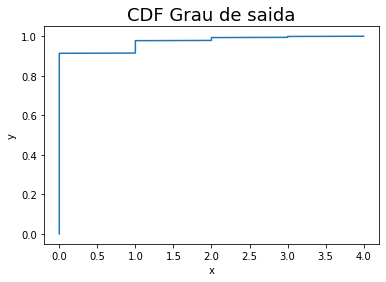

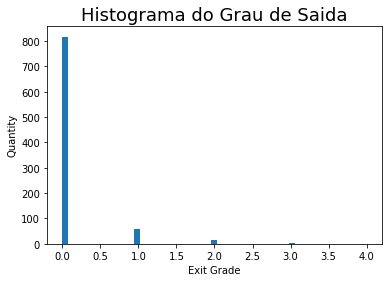

In [ ]:
# List_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1
path = connect_graphs(startList_1, arrivalList_1, departureList_1)


Qtd de arvores finitas:  1793
Qtd de arvores infinitas:  0

mean_exit_grade_root:  0.10094813162297825
Confidence Interval:  (0.08536912876029853, 0.11652713448565796)

mean_max_exit_grade:  1.1461238148354713
Confidence Interval:  (1.1254874211162933, 1.1667602085546493)

Height Mean:  2.0842163970998326
Confidence Interval:  (2.0676846228079917, 2.1007481713916736)

Height Mean of Node:  1.0549358616843285
Confidence Interval:  (1.0459393667969967, 1.063932356571659)

mean_duration:  2.2437255995538203
Confidence Interval:  (2.2144786192812944, 2.2729725798263463)

Mean of Client Attendance:  1.2437255995538203
Confidence Interval:  (1.2144786192812944, 1.2729725798263463)




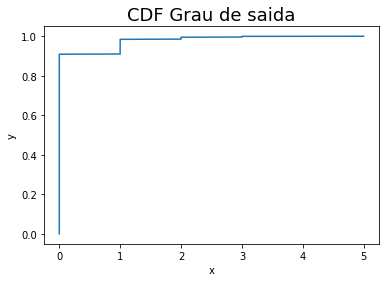

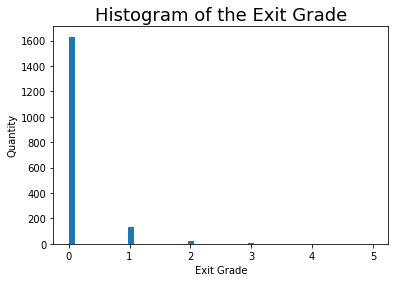

In [ ]:
path = connect_graphs(startList_2, arrivalList_2, departureList_2)

In [ ]:
path = connect_graphs(startList_3, arrivalList_3, departureList_3, clientesSistemaList_3)
print("\n\n")
Image(path)

In [ ]:
path = connect_graphs(startList_4, arrivalList_4, departureList_4, clientesSistemaList_4)
print("\n\n")
Image(path)


Qtd de arvores finitas:  918
Qtd de arvores infinitas:  0

mean_exit_grade_root:  0.07080610021786492
Confidence Interval:  (0.05418248283195959, 0.08742971760377025)

mean_max_exit_grade:  0.985838779956427
Confidence Interval:  (0.9781812217554671, 0.9934963381573869)

Height Mean:  2.1372549019607843
Confidence Interval:  (2.1124287755937683, 2.1620810283278002)

Height Mean of Node:  0.985838779956427
Confidence Interval:  (0.9781812217554671, 0.9934963381573869)

mean_duration:  2.1372549019607843
Confidence Interval:  (2.1124287755937683, 2.1620810283278002)

Mean of Client Attendance:  1.1372549019607843
Confidence Interval:  (1.1124287755937685, 1.1620810283278)




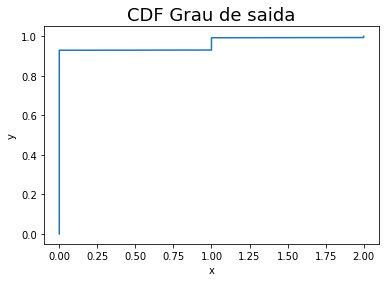

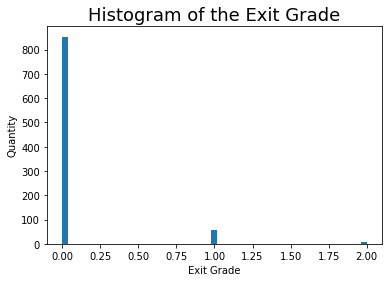

In [ ]:
path = connect_graphs(startList_5, arrivalList_5, departureList_5)


Qtd de arvores finitas:  1770
Qtd de arvores infinitas:  0

mean_exit_grade_root:  0.09661016949152543
Confidence Interval:  (0.08180241675827947, 0.11141792222477138)

mean_max_exit_grade:  1.0700564971751412
Confidence Interval:  (1.0559788698521952, 1.084134124498087)

Height Mean:  2.080225988700565
Confidence Interval:  (2.06421713730928, 2.09623484009185)

Height Mean of Node:  1.0266478342749532
Confidence Interval:  (1.0209069824158419, 1.032388686134064)

mean_duration:  2.1519774011299435
Confidence Interval:  (2.1290972036877363, 2.1748575985721508)

Mean of Client Attendance:  1.1519774011299435
Confidence Interval:  (1.1290972036877363, 1.1748575985721508)




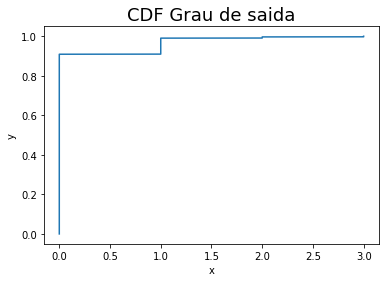

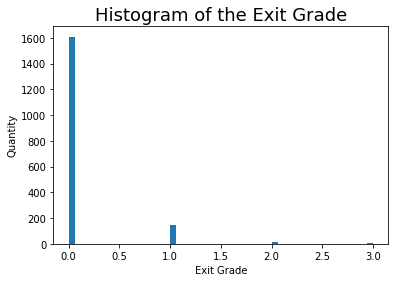

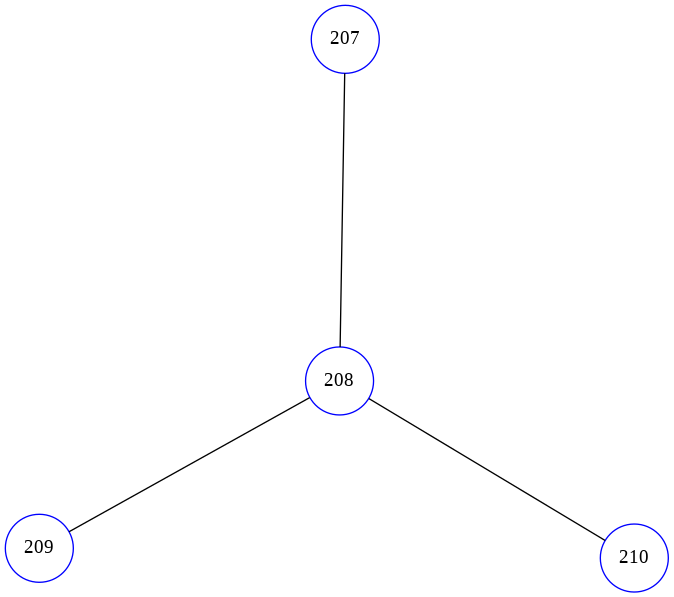

In [ ]:
path = connect_graphs(startList_6, arrivalList_6, departureList_6)
print("\n\n")
Image(path)

In [ ]:
path = connect_graphs(startList_7, arrivalList_7, departureList_7, clientesSistemaList_7)
print("\n\n")
Image(path)

In [ ]:
path = connect_graphs(startList_8, arrivalList_8, departureList_8, clientesSistemaList_8)
print("\n\n")
Image(path)

### Tópico 5.3

Intervalo de confiança apresentado nos exercicios acima, podendo ser possiveis identificar que todos terminam dentro do intervalo de confiança.

## Topico 6

In [ ]:
from seaborn.palettes import xkcd_palette
def calc4(qnt_list,m=0,v=0):
  if qnt_list != 0: 
    v = sum(qnt_list)
    m = len(qnt_list)
  stp = 10000
  stp2 = 0.05
  res = []
  print(m,v)
  for i in range(0,1000):
    atu = 0.5
    nxt = 0
    for i in range(0,200):
      nxt = random.choice([atu-stp2,atu+stp2])
      if nxt <= 0 or nxt >=1:
        acc = 0
      else:
        acc = (((nxt/atu)**(v/1000))*(((1-nxt)/(1-atu))**(m/1000)))
        if acc>1:
          atu = nxt
          continue
        acc = acc**1000
      if acc>random.random():
          atu = nxt
    res.append(atu)
  x = []
  for i in range(0,int(1/stp2)):
    x.append(round(i*stp2,3))
  x.append(1)

  for i in range(0,len(res)):
    res[i] = round(res[i],3)

  prob = []
  for i in x:
    prob.append(res.count(i)/len(res))
  plt.title("Result")
  plt.xlabel("State")
  plt.ylabel("Probability")
  plt.plot(x,prob, color='red')
  plt.show()
  print(confidence_interval(res))

### Tópico 6.1

100 25


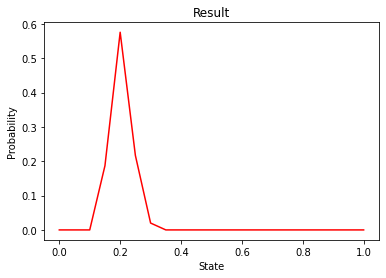

(0.2035, 0.2014, 0.2056)
100 100


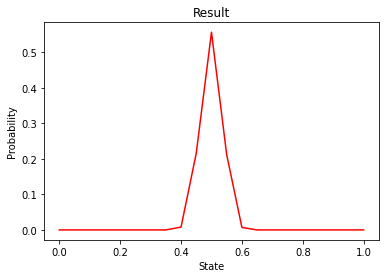

(0.4997, 0.4975, 0.5019)
7981 30628


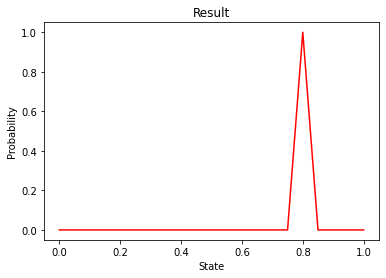

(0.8, 0.8, 0.8)
4964 5040


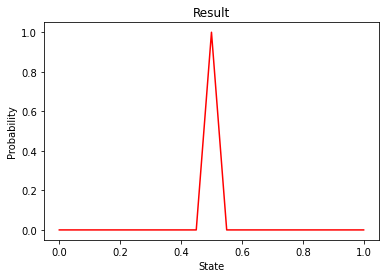

(0.5, 0.5, 0.5)


In [ ]:
calc4(0,100,25)

calc4(0,100,100)

startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(1000, 8, 10, 1,'m',0)
calc4(clientesSistemaList_1)

startList_1, arrivalList_1, response_List_1, serviceList_1, departureList_1, waitList_1, clientesSistemaList_1 = simulator(1000, 5, 10, 1,'m',0)
calc4(clientesSistemaList_1)

### Tópico 6.2

### Tópico 6.3

## Criatividade

### Simulation: simT=5000, $\lambda$=5, $\mu$=10, $1/\lambda$=0.2, $1/\mu$=0.1, $\Qtd_de_Servidores$=1

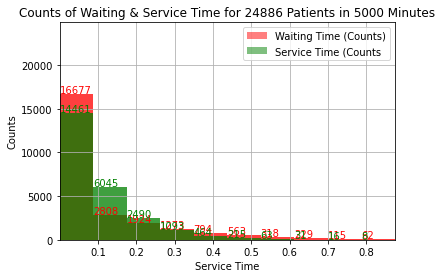




0.10068 [average wait]
0.1 [expect wait]
1.007 [average customer in system]
1.0 [expect customer in system]

Confidence Interval to waitList:  (0.1007, 0.0986, 0.1028)
Confidence Interval to serviceList:  (0.1007, 0.0994, 0.1019)
Confidence Interval to qnt_list:  (1.0087, 0.9912, 1.0262)





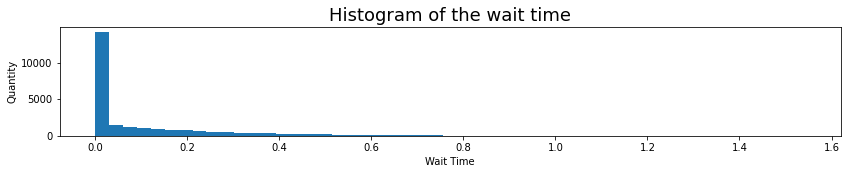

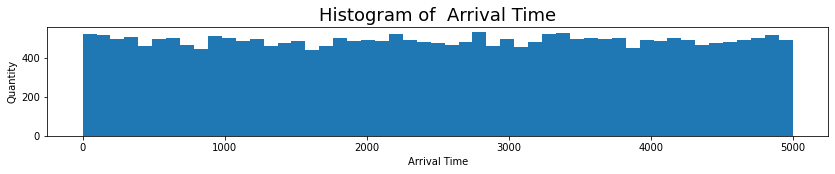

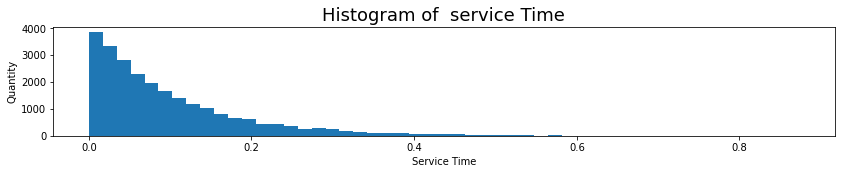

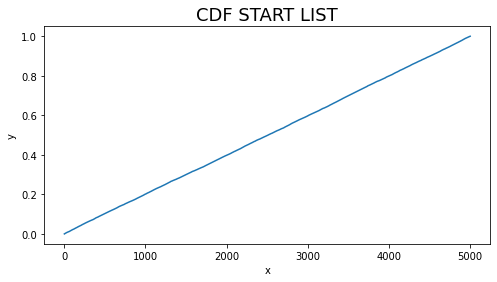

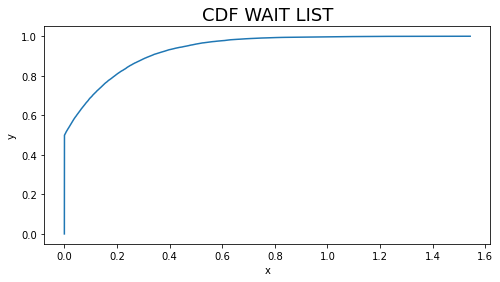

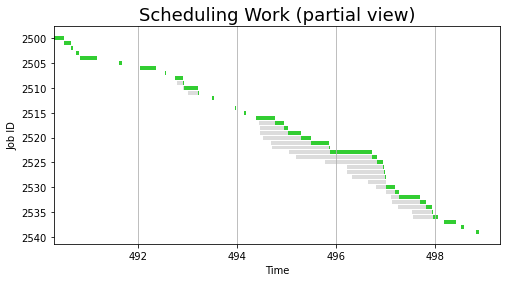

### Simulation: simT=5000, $\lambda$=10, $\mu$=10, $1/\lambda$=0.1, $1/\mu$=0.1, $\Qtd_de_Servidores$=2

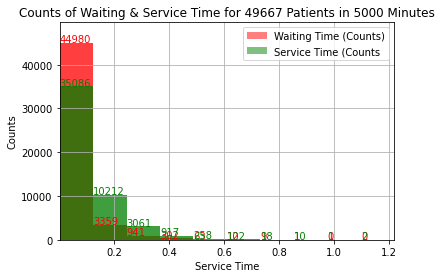




0.0323 [average wait]
0.03333 [expect wait]
1.323 [average customer in system]
1.333 [expect customer in system]

Confidence Interval to waitList:  (0.0323, 0.0317, 0.0329)
Confidence Interval to serviceList:  (0.1, 0.0991, 0.1009)
Confidence Interval to qnt_list:  (1.3137, 1.3009, 1.3264)





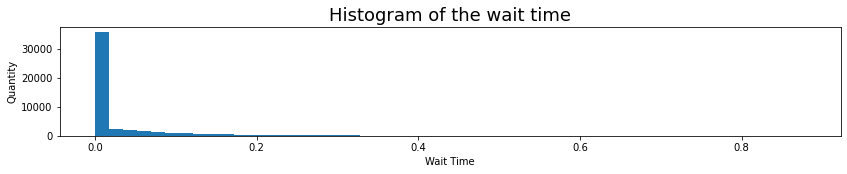

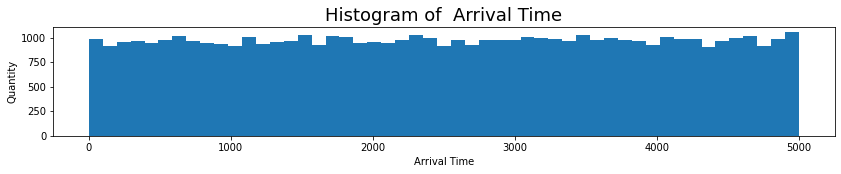

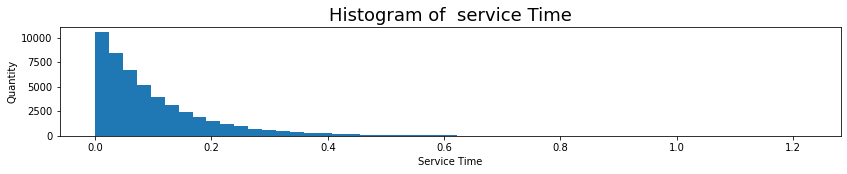

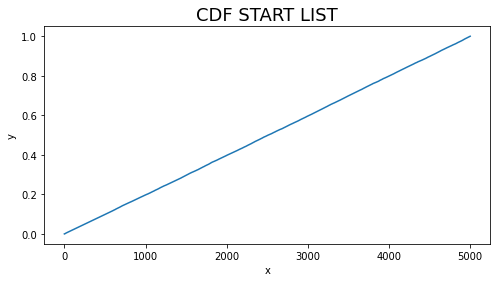

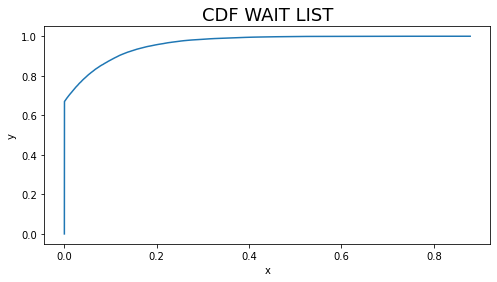

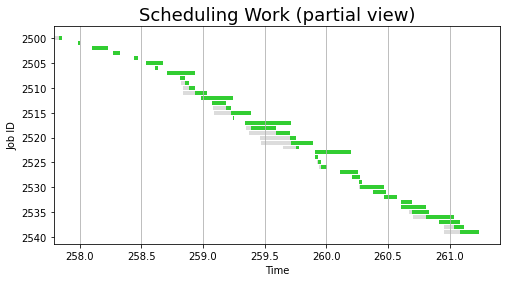

### Simulation: simT=5000, $\lambda$=5, $\mu$=10, $1/\lambda$=0.2, $1/\mu$=0.1, $\Qtd_de_Servidores$=2

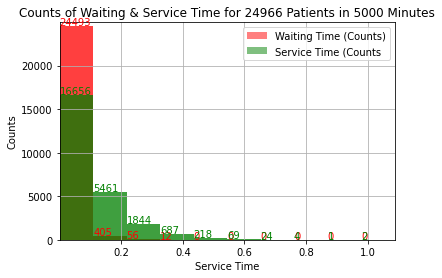




0.00659 [average wait]
0.00667 [expect wait]
0.532 [average customer in system]
0.533 [expect customer in system]

Confidence Interval to waitList:  (0.0066, 0.0062, 0.0069)
Confidence Interval to serviceList:  (0.0997, 0.0985, 0.101)
Confidence Interval to qnt_list:  (0.5378, 0.5281, 0.5474)





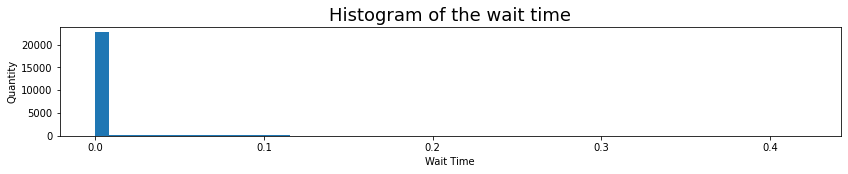

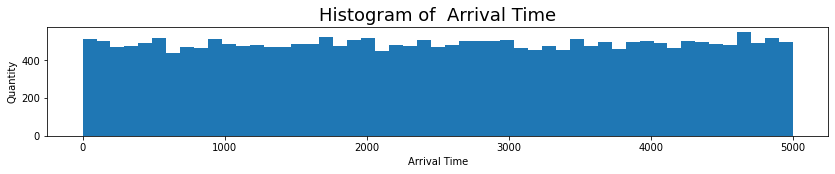

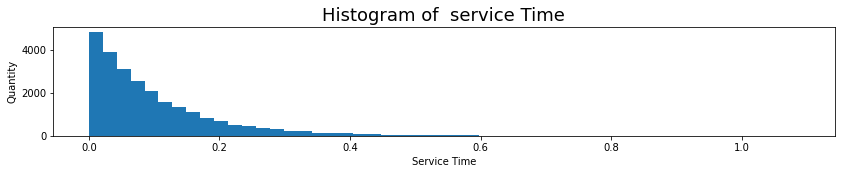

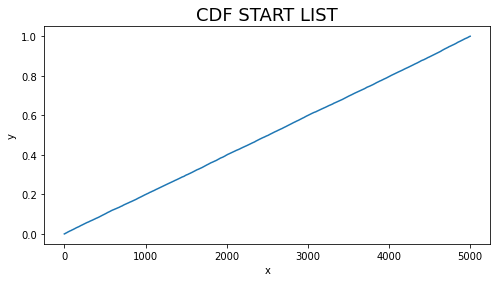

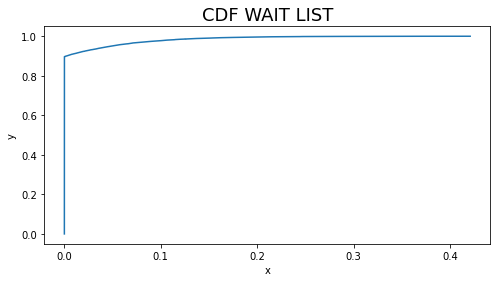

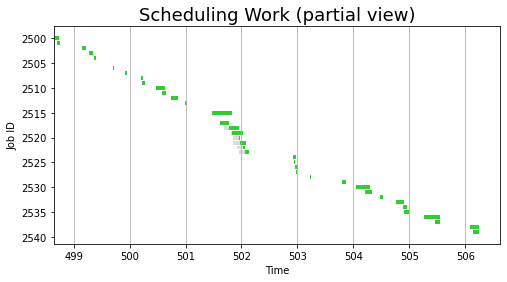

In [ ]:
a= simulator(5000, 5, 10, 1,'m',1)
b= simulator(5000, 10, 10, 2,'m',1)
e= simulator(5000, 5, 10, 2,'m',1)

In [ ]:
c= simulator(5000, 1, 10, 1,'m',1)
d= simulator(5000, 10, 10, 10,'m',1)
f= simulator(5000, 1, 10, 10,'m',1)